In [57]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [58]:
import os
import glob

import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
import sklearn.feature_selection as fs

from seaborn import clustermap
import matplotlib.pyplot as plt

import plotly.express as px

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from Bio import Phylo

from modules.hmm import get_hits, get_seqs

In [59]:

import seaborn as sns
sns.set(font_scale=0.25)

In [60]:
DATA_DIR = "../data/runs/aquificota/2024-10-08/"

SOURCES = ["barosa"]

E_VALUE_THR = 1e-20
ABSENCE_THR = 0.90
CORE_THR    = 0.90

CLUSTERMAP_METHOD = "ward"
CLUSTERMAP_METRIC = "hamming"

SIGNIFICANCE_THR = 0.01

RANDOM_SEED = 666

## Metadata

In [61]:
# Get correct HMM model name mapping
hmm_mapping = {}

for hmm_path in glob.glob("../data/profiles/barosa/*.hmm"):
    hmm_filename = os.path.basename(hmm_path)

    with open(hmm_path, mode="r") as handle:
        hmm_name = handle.readlines()[1]\
            .replace("NAME  ", "")\
            .replace("\n", "")

        hmm_mapping[hmm_filename] = hmm_name

In [62]:
metadata_df = pd.read_excel(
    os.path.join(
        "../data/",
        "Aquificota_Revised_Biogeochem_genes.xlsx"
    ),
    sheet_name="3-OCT",
    engine="openpyxl"
)

metadata_df = metadata_df\
    .dropna(how="all", axis=0)\
    .dropna(how="all", axis=1)

# Fix HMM names
# NOTE: missing mapping entries will result in errors
metadata_df = metadata_df.rename(columns={"hmm model": "hmm_model"})
metadata_df["hmm_model"] = metadata_df["hmm_model"].map(hmm_mapping)

# Format cycle column
metadata_df["Cycle"] = metadata_df["Cycle"].str.strip()

# Format HMM column to fit file format
metadata_df["hmm_model"] = metadata_df["hmm_model"]\
    .apply(lambda row: f"{str(row).replace('.hmm', '')}")

metadata_df

Cycle                    Pathway  \
0    Arsenic         Arsenic metabolism   
1    Arsenic         Arsenic metabolism   
2    Arsenic         Arsenic metabolism   
3    Arsenic         Arsenic metabolism   
4     Carbon  Carbon monoxide oxidation   
..       ...                        ...   
216     Iron      siderophore transport   
217     Iron      siderophore transport   
218     Iron      siderophore transport   
219     Iron      siderophore transport   
220     Iron             iron transport   

                                                  Name  \
0                                   Arsenate reductase   
1                                   Arsenate reductase   
2                                     Arsenate oxidase   
3                                     Arsenate oxidase   
4                aerobic carbon-monoxide dehydrogenase   
..                                                 ...   
216  Sid_LbtC_Legiobactin_PAP2_superfamily_Legionel...   
217  Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_...   
218  Sid_VabS_Vanchrobactin_Export_Vibrio_anguillar...   
219  Sid_YqjH_NADPH-dep_ferric_chelate_reductase_en...   
220                                                zip   

                                   Sub_name  \
0      Arsenate reductase glutaredoxin type   
1       Arsenate reductase thioredoxin type   
2    Arsenate oxidase molybdopterin subunit   
3            Arsenite oxidase large subunit   
4                                       NaN   
..                                      ...   
216                                     NaN   
217                                     NaN   
218                                     NaN   
219                                     NaN   
220                                     NaN   

                                                  Gene KOfam_ACC        EC  \
0                                                 arsC    K00537  1.20.4.1   
1                                                 arsC    K03741  1.20.4.4   
2                                                 arxC       NaN       NaN   
3                                                 aioA    K08356  1.20.2.1   
4                                                 coxL    K03520   1.2.5.3   
..                                                 ...       ...       ...   
216  Sid_LbtC_Legiobactin_PAP2_superfamily_Legionel...       NaN       NaN   
217  Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_...       NaN       NaN   
218  Sid_VabS_Vanchrobactin_Export_Vibrio_anguillar...       NaN       NaN   
219  Sid_YqjH_NADPH-dep_ferric_chelate_reductase_en...       NaN       NaN   
220                                                zip       NaN       NaN   

    Catalyst_metal Tree_annotation Environment  \
0            Mo, W  Metal_cofactor   reductive   
1            Mo, W  Metal_cofactor   reductive   
2               Mo  Metal_cofactor   oxidative   
3               Mo  Metal_cofactor   oxidative   
4             CuMo  Metal_cofactor   reductive   
..             ...             ...         ...   
216            NaN             NaN         NaN   
217            NaN             NaN         NaN   
218            NaN             NaN         NaN   
219            NaN             NaN         NaN   
220            NaN             NaN         NaN   

                                             hmm_model hmm model_DB  \
0                                            arsC_glut    Metabolic   
1                                            arsC_thio    Metabolic   
2                                                 arxA    Metabolic   
3                                                 aioA    Metabolic   
4                                               K03520    Metabolic   
..                                                 ...          ...   
216  Sid_LbtC_Legiobactin_PAP2_superfamily_Legionel...      FeGenie   
217  Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_...      FeGenie   
218  Sid_VabS_Vanchrobactin_Export_Vibrio_anguillar

## Raw data

In [63]:
hits_path = os.path.join(
    DATA_DIR,
    "HighQ_Aquificota_Sequences_AA_hmmer.txt"
)
seqs_path = os.path.join(
    DATA_DIR,
    "HighQ_Aquificota_Sequences_AA.fa"
)

hits_df = get_hits(hits_path)
seqs_df = get_seqs(seqs_path)

hits_df = pd.merge(
    left=hits_df,
    right=seqs_df.rename(columns={"seq_id": "target_name"}),
    how="left",
    on="target_name"
)

# Create MAG and gene caller ID columns
hits_df["mag"] = hits_df["target_name"]\
    .str.split("_").str[:-1]\
    .apply(lambda row: "_".join(row))
hits_df["gene_caller_id"] = hits_df["target_name"]\
    .str.split("_").str[-1]

# Filter by selected source (do it here for removing "barosa_" in the next step)
hits_df = hits_df[hits_df["query_name"].str.startswith(tuple(SOURCES))]

# Add metadata information
hits_df["query_name"] = hits_df["query_name"].str.replace("barosa_", "")
hits_df = pd.merge(
    left=hits_df,
    right=metadata_df,
    left_on="query_name",
    right_on="hmm_model",
    how="left"
)

hits_df

target_name target_accession  \
0              Desulfurobacterium_atlanticum_DSM_15668_32                -   
1                       Thermocrinis_jamiesonii_GBS1_1354                -   
2                         Thermocrinis_sp_CTOTU25738_1171                -   
3              Desulfurobacterium_atlanticum_DSM_15668_26                -   
4       Hydrogenothermaceae_bacterium_356_308_metabat2...                -   
...                                                   ...              ...   
109341  Aquificaceae_bacterium_S012_metabat2_scaf2bin_...                -   
109342  Aquificaceae_bacterium_S139_metabat1_scaf2bin_...                -   
109343            Aquificaceae_bacterium_S140_64_esom_657                -   
109344  Aquificaceae_bacterium_S140_metabat1_scaf2bin_...                -   
109345  Aquificaceae_bacterium_S146_metabat1_scaf2bin_...                -   

                         query_name query_accession  e_value_full_seq  \
0       FbpC-iron_uptake_ATPase-rep               -     5.200000e-109   
1       FbpC-iron_uptake_ATPase-rep               -     1.400000e-107   
2       FbpC-iron_uptake_ATPase-rep               -     2.500000e-107   
3       FbpC-iron_uptake_ATPase-rep               -      9.300000e-95   
4       FbpC-iron_uptake_ATPase-rep               -      1.300000e-93   
...                             ...             ...               ...   
109341                       K01959               -      4.600000e+00   
109342                       K01959               -      4.600000e+00   
109343                       K01959               -      4.600000e+00   
109344                       K01959               -      4.600000e+00   
109345                       K01959               -      4.600000e+00   

        score_full_seq  bias_full_seq  e_value_best_dom  score_best_dom  \
0                367.8            0.1     1.800000e-108           366.1   
1                363.2            0.0     1.700000e-107           362.9   
2                362.3            0.0     3.400000e-107           361.9   
3                321.0            0.0      2.300000e-93           316.4   
4                317.2            0.0      1.600000e-93           316.9   
...                ...            ...               ...             ...   
109341             9.5            0.0      7.000000e+00             8.9   
109342             9.5            0.0      7.000000e+00             8.9   
109343             9.5            0.0      7.000000e+00             8.9   
109344             9.5            0.0      7.000000e+00             8.9   
109345             9.5            0.0      7.000000e+00             8.9   

        bias_best_dom  ...  Sub_name                         Gene  KOfam_ACC  \
0                 0.1  ...       NaN  FbpC-iron_uptake_ATPase-rep        NaN   
1                 0.0  ...       NaN  FbpC-iron_uptake_ATPase-rep        NaN   
2                 0.0  ...       NaN  FbpC-iron_uptake_ATPase-rep        NaN   
3                 0.0  ...       NaN  FbpC-iron_uptake_ATPase-rep        NaN   
4                 0.0  ...       NaN  FbpC-iron_uptake_ATPase-rep        NaN   
...               ...  ...       ...                          ...        ...   
109341            0.0  ...       NaN                         pycA     K01959   
109342            0.0  ...       NaN                         pycA     K01959   
109343            0.0  ...       NaN                         pycA     K01959   
109344            0.0  ...       NaN                         pycA     K01959   
109345            0.0  ...       NaN                         pycA     K01959   

             EC  Catalyst_metal          Tree_annotation  Environment  \
0           NaN             NaN                      NaN          NaN   
1           NaN             NaN                      NaN          NaN   
2           NaN             NaN                      NaN          NaN   
3           NaN             NaN                      NaN          NaN   
4    

In [64]:
# Keep a copy without filtering for further plots
raw_hits_df = hits_df.copy()

## Preprocessing

In [65]:
# Filter by e-value threshold
hits_df = hits_df[hits_df["e_value_full_seq"] <= E_VALUE_THR]

# Filter by bitscore threshold
hits_df = hits_df.loc[
    hits_df["score_full_seq"] >= hits_df["Hmm detecting threshold"]
]

# Get only those hits with the lowest E-value
hits_df = hits_df.loc[
    hits_df.groupby("target_name")["e_value_full_seq"].idxmin()
].reset_index(drop=True)

hits_df

target_name target_accession  \
0                        Aquifex_aeolicus_HyVt_501_1111                -   
1                        Aquifex_aeolicus_HyVt_501_1348                -   
2                        Aquifex_aeolicus_HyVt_501_1508                -   
3                         Aquifex_aeolicus_HyVt_501_151                -   
4                        Aquifex_aeolicus_HyVt_501_1519                -   
...                                                 ...              ...   
5767  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
5768  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
5769  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
5770  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
5771  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   

                                             query_name query_accession  \
0                                                K21308               -   
1                                                  DmkB               -   
2                                         sqr_alignment               -   
3                                                K01491               -   
4     Iron_uptake_YfeB_Chelated_iron_transport_syste...               -   
...                                                 ...             ...   
5767                                               corA     TIGR00383.1   
5768                      LbtU-LvtA-PiuA-PirA-RhtA-ViuA               -   
5769                                               FeoE               -   
5770                                 nife-group-1.mafft               -   
5771                                          TIGR02866       TIGR02866   

      e_value_full_seq  score_full_seq  bias_full_seq  e_value_best_dom  \
0        2.000000e-106           359.3            5.8     2.300000e-106   
1         6.300000e-35           124.8            0.0      7.200000e-35   
2        5.800000e-145           487.2            0.0     7.300000e-145   
3        2.400000e-127           430.0            0.2     2.900000e-127   
4         4.600000e-23            85.5            0.0      1.100000e-15   
...                ...             ...            ...               ...   
5767      1.500000e-58           202.6            7.1      1.800000e-58   
5768      6.800000e-25            91.3            3.6      1.400000e-15   
5769      1.100000e-24            91.3            2.5      1.500000e-24   
5770     2.900000e-205           687.4            0.0     3.300000e-205   
5771      4.900000e-48           167.3            3.7      7.200000e-48   

      score_best_dom  bias_best_dom  ...                         Sub_name  \
0              359.2            5.8  ...                              NaN   
1              124.6            0.0  ...                              NaN   
2              486.9            0.0  ...                              NaN   
3              429.8            0.2  ...                              NaN   
4               61.3            0.0  ...                              NaN   
...              ...            ...  ...                              ...   
5767           202.4            7.1  ...                              NaN   
5768            60.6            1.6  ...                              NaN   
5769            90.8            2.5  ...                              NaN   
5770           687.2            0.0  ...                     nife-group-1   
5771           166.7            3.7  ...  Cytochrome-c oxidase subunit II   

                                                   Gene  KOfam_ACC       EC  \
0                                                  soeB     K21308  1.8.5.6   
1                                                  DmkB        NaN      NaN   
2                                                   sqr     K17218  1.8.5.4   
3                                                  folD     K01491  1.5.1.5   
4     Iro

#### Saving sequences for each HMM

In [21]:
sequences_dir = os.path.join(
    DATA_DIR,
    "sequences"
)
os.makedirs(sequences_dir, exist_ok=True)

for hmm_model in hits_df["query_name"].unique():

    hmm_path = os.path.join(
        sequences_dir,
        f"{hmm_model}.fasta"
    )

    hmm_df = hits_df[hits_df["query_name"] == hmm_model]

    hmm_seqs = [
        SeqRecord(
            Seq(row["seq"]),
            id=row["target_name"],
            name="",
            description="",
        )
        for _, row in hmm_df.iterrows()
    ]

    SeqIO.write(hmm_seqs, hmm_path, "fasta")


#### Creating the heatmap dataframe

In [22]:
# Presence/abscence (remove for having the counts of many-vs-many)
heat_df = hits_df[["mag", "query_name"]].copy()

heat_df = heat_df.rename(columns={"query_name": "profile"})
heat_df = heat_df\
    .value_counts()\
    .reset_index(drop=False)\
    .rename(columns={0: "count"})

# Add collumn for displaying presence/absence
heat_df["presence"] = heat_df["count"].apply(lambda row: int(bool(row)))

# Filter profiles
heat_df["source"] = heat_df["profile"].str.split("_").str[0]

heat_df = heat_df.pivot(
    index="mag",
    columns="profile",
    values="presence"
)

# Format columns
heat_df.columns = heat_df.columns.str.replace("barosa.source.hmm_", "")

# Fill NaNs
heat_df = heat_df.fillna(0.0)

heat_df

profile                                             Carb_anhydrase  \
mag                                                                  
Aquifex_aeolicus_HyVt_501                                      1.0   
Aquifex_aeolicus_SZUA_1413                                     0.0   
Aquifex_aeolicus_SZUA_1501                                     0.0   
Aquifex_aeolicus_SZUA_1519                                     0.0   
Aquifex_aeolicus_VF5                                           0.0   
...                                                            ...   
Thermovibrio_sp_S012_127_esom                                  0.0   
Thermovibrio_sp_S141_83                                        0.0   
Venenivibrio_stagnispumantis_DSM_18763                         0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...             0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...             0.0   

profile                                             Cyc2_repCluster1  \
mag                                                                    
Aquifex_aeolicus_HyVt_501                                        1.0   
Aquifex_aeolicus_SZUA_1413                                       0.0   
Aquifex_aeolicus_SZUA_1501                                       0.0   
Aquifex_aeolicus_SZUA_1519                                       0.0   
Aquifex_aeolicus_VF5                                             0.0   
...                                                              ...   
Thermovibrio_sp_S012_127_esom                                    0.0   
Thermovibrio_sp_S141_83                                          0.0   
Venenivibrio_stagnispumantis_DSM_18763                           0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...               0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...               0.0   

profile                                             Cyc2_repCluster2  \
mag                                                                    
Aquifex_aeolicus_HyVt_501                                        0.0   
Aquifex_aeolicus_SZUA_1413                                       0.0   
Aquifex_aeolicus_SZUA_1501                                       0.0   
Aquifex_aeolicus_SZUA_1519                                       0.0   
Aquifex_aeolicus_VF5                                             0.0   
...                                                              ...   
Thermovibrio_sp_S012_127_esom                                    0.0   
Thermovibrio_sp_S141_83                                          0.0   
Venenivibrio_stagnispumantis_DSM_18763                           0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...               0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...               0.0   

profile                                             DFE_0449  DFE_0450  \
mag                                                                      
Aquifex_aeolicus_HyVt_501                                0.0       0.0   
Aquifex_aeolicus_SZUA_1413                               0.0       0.0   
Aquifex_aeolicus_SZUA_1501                               0.0       0.0   
Aquifex_aeolicus_SZUA_1519                               0.0       0.0   
Aquifex_aeolicus_VF5                                     0.0       0.0   
...                                                      ...       ...   
Thermovibrio_sp_S012_127_esom                            0.0       0.0   
Thermovibrio_sp_S141_83                                  0.0       0.0   
Venenivibrio_stagnispumantis_DSM_18763                   0.0       0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...       0.0       0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...       0.0       0.0   

profile                                             DFE_0451  DFE_0461  \
mag                                                                      
Aquifex_aeolicus_HyVt_501                                1.0       1.0   
Aquifex_aeolicus_SZUA_1413    

#### Creating the heatmap annotations

In [23]:
metadata_df["cycle_colors"] = metadata_df["Cycle"].map({
    "Arsenic": "#e8c5aaff",
    "Carbon": "#75a56bff",
    "Methane": "#e8dfe2ff",
    "Nitrogen": "#386b9aff",
    "Oxygen": "#b9a3cbff",
    "Photosynthesis": "#7fd68bff",
    "Sulfur": "#edd970ff",
    "Hydrogen": "#8EC3E6",
    "Iron": "#861f2bff",
    "Selenium": "#a78873ff",
    "Transporters": "#F4A261"
})
cycle_colors = metadata_df\
    .set_index("hmm_model")["cycle_colors"]\
    .rename("Cycle")
cycle_colors

hmm_model
arsC_glut                                                                                  #e8c5aaff
arsC_thio                                                                                  #e8c5aaff
arxA                                                                                       #e8c5aaff
aioA                                                                                       #e8c5aaff
K03520                                                                                     #75a56bff
                                                                                             ...    
Sid_LbtC_Legiobactin_PAP2_superfamily_Legionella_oakridgensis_AHE65915.1_180604            #861f2bff
Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_180623                                       #861f2bff
Sid_VabS_Vanchrobactin_Export_Vibrio_anguillarum_CAJ45638.1_180623                         #861f2bff
Sid_YqjH_NADPH-dep_ferric_chelate_reductase_enterobactin_Q46871_Escherichia_coli_

In [24]:
tax_df = pd.read_csv(
    os.path.join(
        "../data/",
        "Aquificota_gtdb_classification.csv"
    )
)
tax_df["Genomes"] = tax_df["Genomes"].str.split("\\td__").str[0]
tax_df["Family"] = tax_df["Family"].str.split("__").str[-1]
tax_df["family_colors"] = tax_df["Family"].map({
    "Aquificaceae": "#f0ba7cff",
    "Desulfurobacteriaceae": "#E07A5F",
    "DSM-5069": "white",
    "Hydrogenothermaceae": "#81B29A",
    "QOAS01": "#3D405B",
    "Thermotogaceae": "white"
})
family_colors = tax_df\
    .set_index("Genomes")["family_colors"]\
    .rename("Family")
family_colors

Genomes
Aquifex_aeolicus_HyVt_501                                     #f0ba7cff
Aquifex_aeolicus_SZUA_1413                                    #f0ba7cff
Aquifex_aeolicus_SZUA_1501                                      #3D405B
Aquifex_aeolicus_SZUA_1519                                      #3D405B
Aquifex_aeolicus_VF5                                          #f0ba7cff
                                                                ...    
Thermovibrio_sp_S012_127_esom                                   #E07A5F
Thermovibrio_sp_S141_83                                         #E07A5F
Venenivibrio_stagnispumantis_DSM_18763                          #81B29A
unclassified_Aquificaceae_Obs3_genome_041_Obs3_genome_041     #f0ba7cff
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN__048_sub_1    #f0ba7cff
Name: Family, Length: 175, dtype: object

## Core HMMs

In [27]:
core_hmms = heat_df.columns[
    (heat_df == 1).mean() >= CORE_THR
]
core_hmms = pd.DataFrame(
    heat_df[core_hmms].columns.tolist(),
    columns=["hmm_model"]
)

merged_families = pd.merge(
    left=core_hmms, 
    right=metadata_df, 
    left_on="hmm_model", 
    right_on="hmm_model",
    how="left"
)
merged_families.to_csv(
    os.path.join(
        DATA_DIR,
        f"core_genes_aquificota.csv"
    ),
    index=False
)

merged_families

hmm_model   Cycle  \
0                                               DmkB    Iron   
1                                             FeoB_N    Iron   
2  Iron_uptake_YfeB_Chelated_iron_transport_syste...    Iron   
3                                             K00169  Carbon   
4                                             K01491  Carbon   
5                                             K01677  Carbon   
6                                             K01902  Carbon   
7                                gamma_sel_MSA_tohmm  Carbon   

                Pathway                                               Name  \
0        Iron reduction                                               DmkB   
1        iron transport                                             FeoB_N   
2        iron transport  Iron_uptake_YfeB_Chelated_iron_transport_syste...   
3  Carbon fixation-rTCA                                Pyruvate synthetase   
4    Carbon fixation-WL            methylenetetrahydrofolate dehydrogenase   
5  Carbon fixation-rTCA                                 Fumarate hydratase   
6  Carbon fixation-rTCA                            Succinyl-CoA synthetase   
7       Carbon fixation                      Carbonic anhydrase gamma type   

  Sub_name                                               Gene KOfam_ACC  \
0      NaN                                               DmkB       NaN   
1      NaN                                             FeoB_N       NaN   
2      NaN  Iron_uptake_YfeB_Chelated_iron_transport_syste...       NaN   
3      NaN                                               porA    K00169   
4      NaN                                               folD    K01491   
5      NaN                                               fumA    K01677   
6      NaN                                               sucD    K01902   
7      NaN                                           CA_gamma       NaN   

        EC Catalyst_metal          Tree_annotation Environment hmm model_DB  \
0      NaN            NaN                      NaN         NaN    Metabolic   
1      NaN            NaN                      NaN         NaN      FeGenie   
2      NaN            NaN                      NaN         NaN      FeGenie   
3  1.2.7.1            NaN  carbon_fixation_version         NaN        KoFAM   
4  1.5.1.5            NaN  carbon_fixation_version         NaN        KoFAM   
5  4.2.1.2            NaN  carbon_fixation_version         NaN        KoFAM   
6  6.2.1.5            NaN  carbon_fixation_version         NaN        KoFAM   
7      NaN            NaN                      NaN         NaN       Alongo   

   Hmm detecting threshold cycle_colors  
0                    25.00    #861f2bff  
1                   120.40    #861f2bff  
2                    46.60    #861f2bff  
3                   294.07    #75a56bff  
4                   402.00    #75a56bff  
5                   310.67    #75a56bff  
6                   363.47    #75a56bff  
7                    25.00    #75a56bff

## Global clustermaps

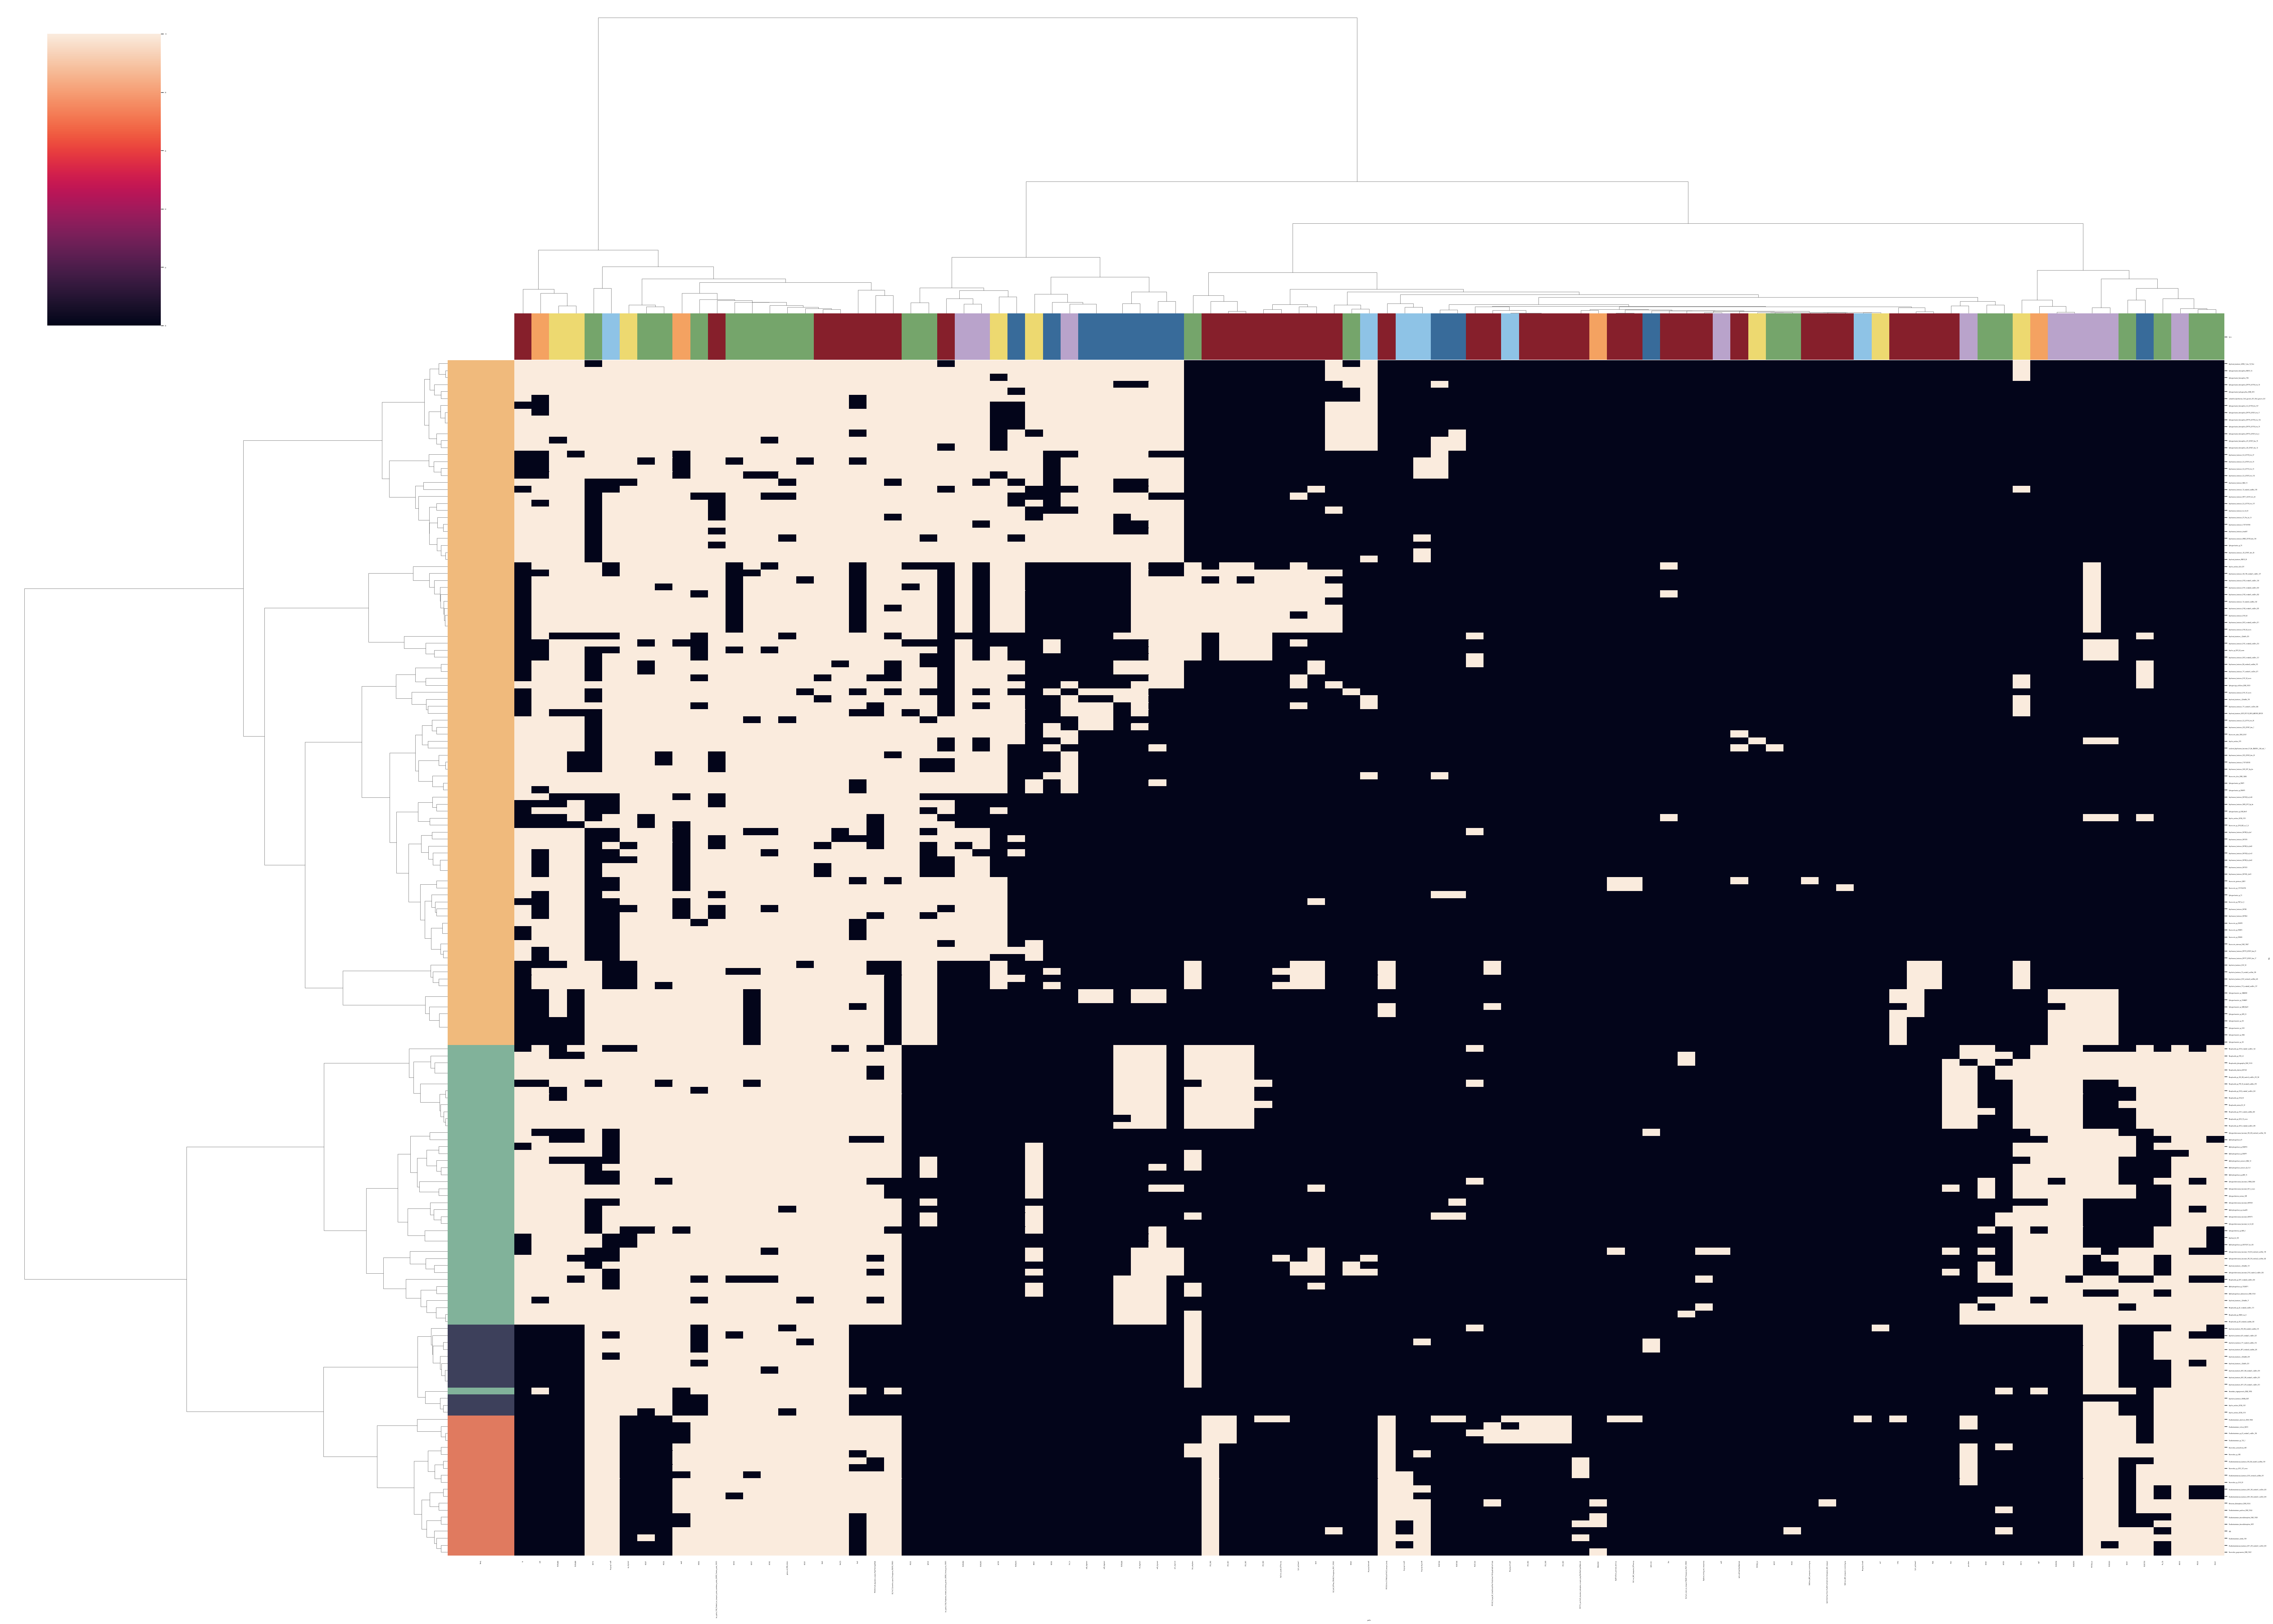

In [29]:
clustermap(
    data=heat_df,
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-complete.svg"
    ),
    dpi=300
)

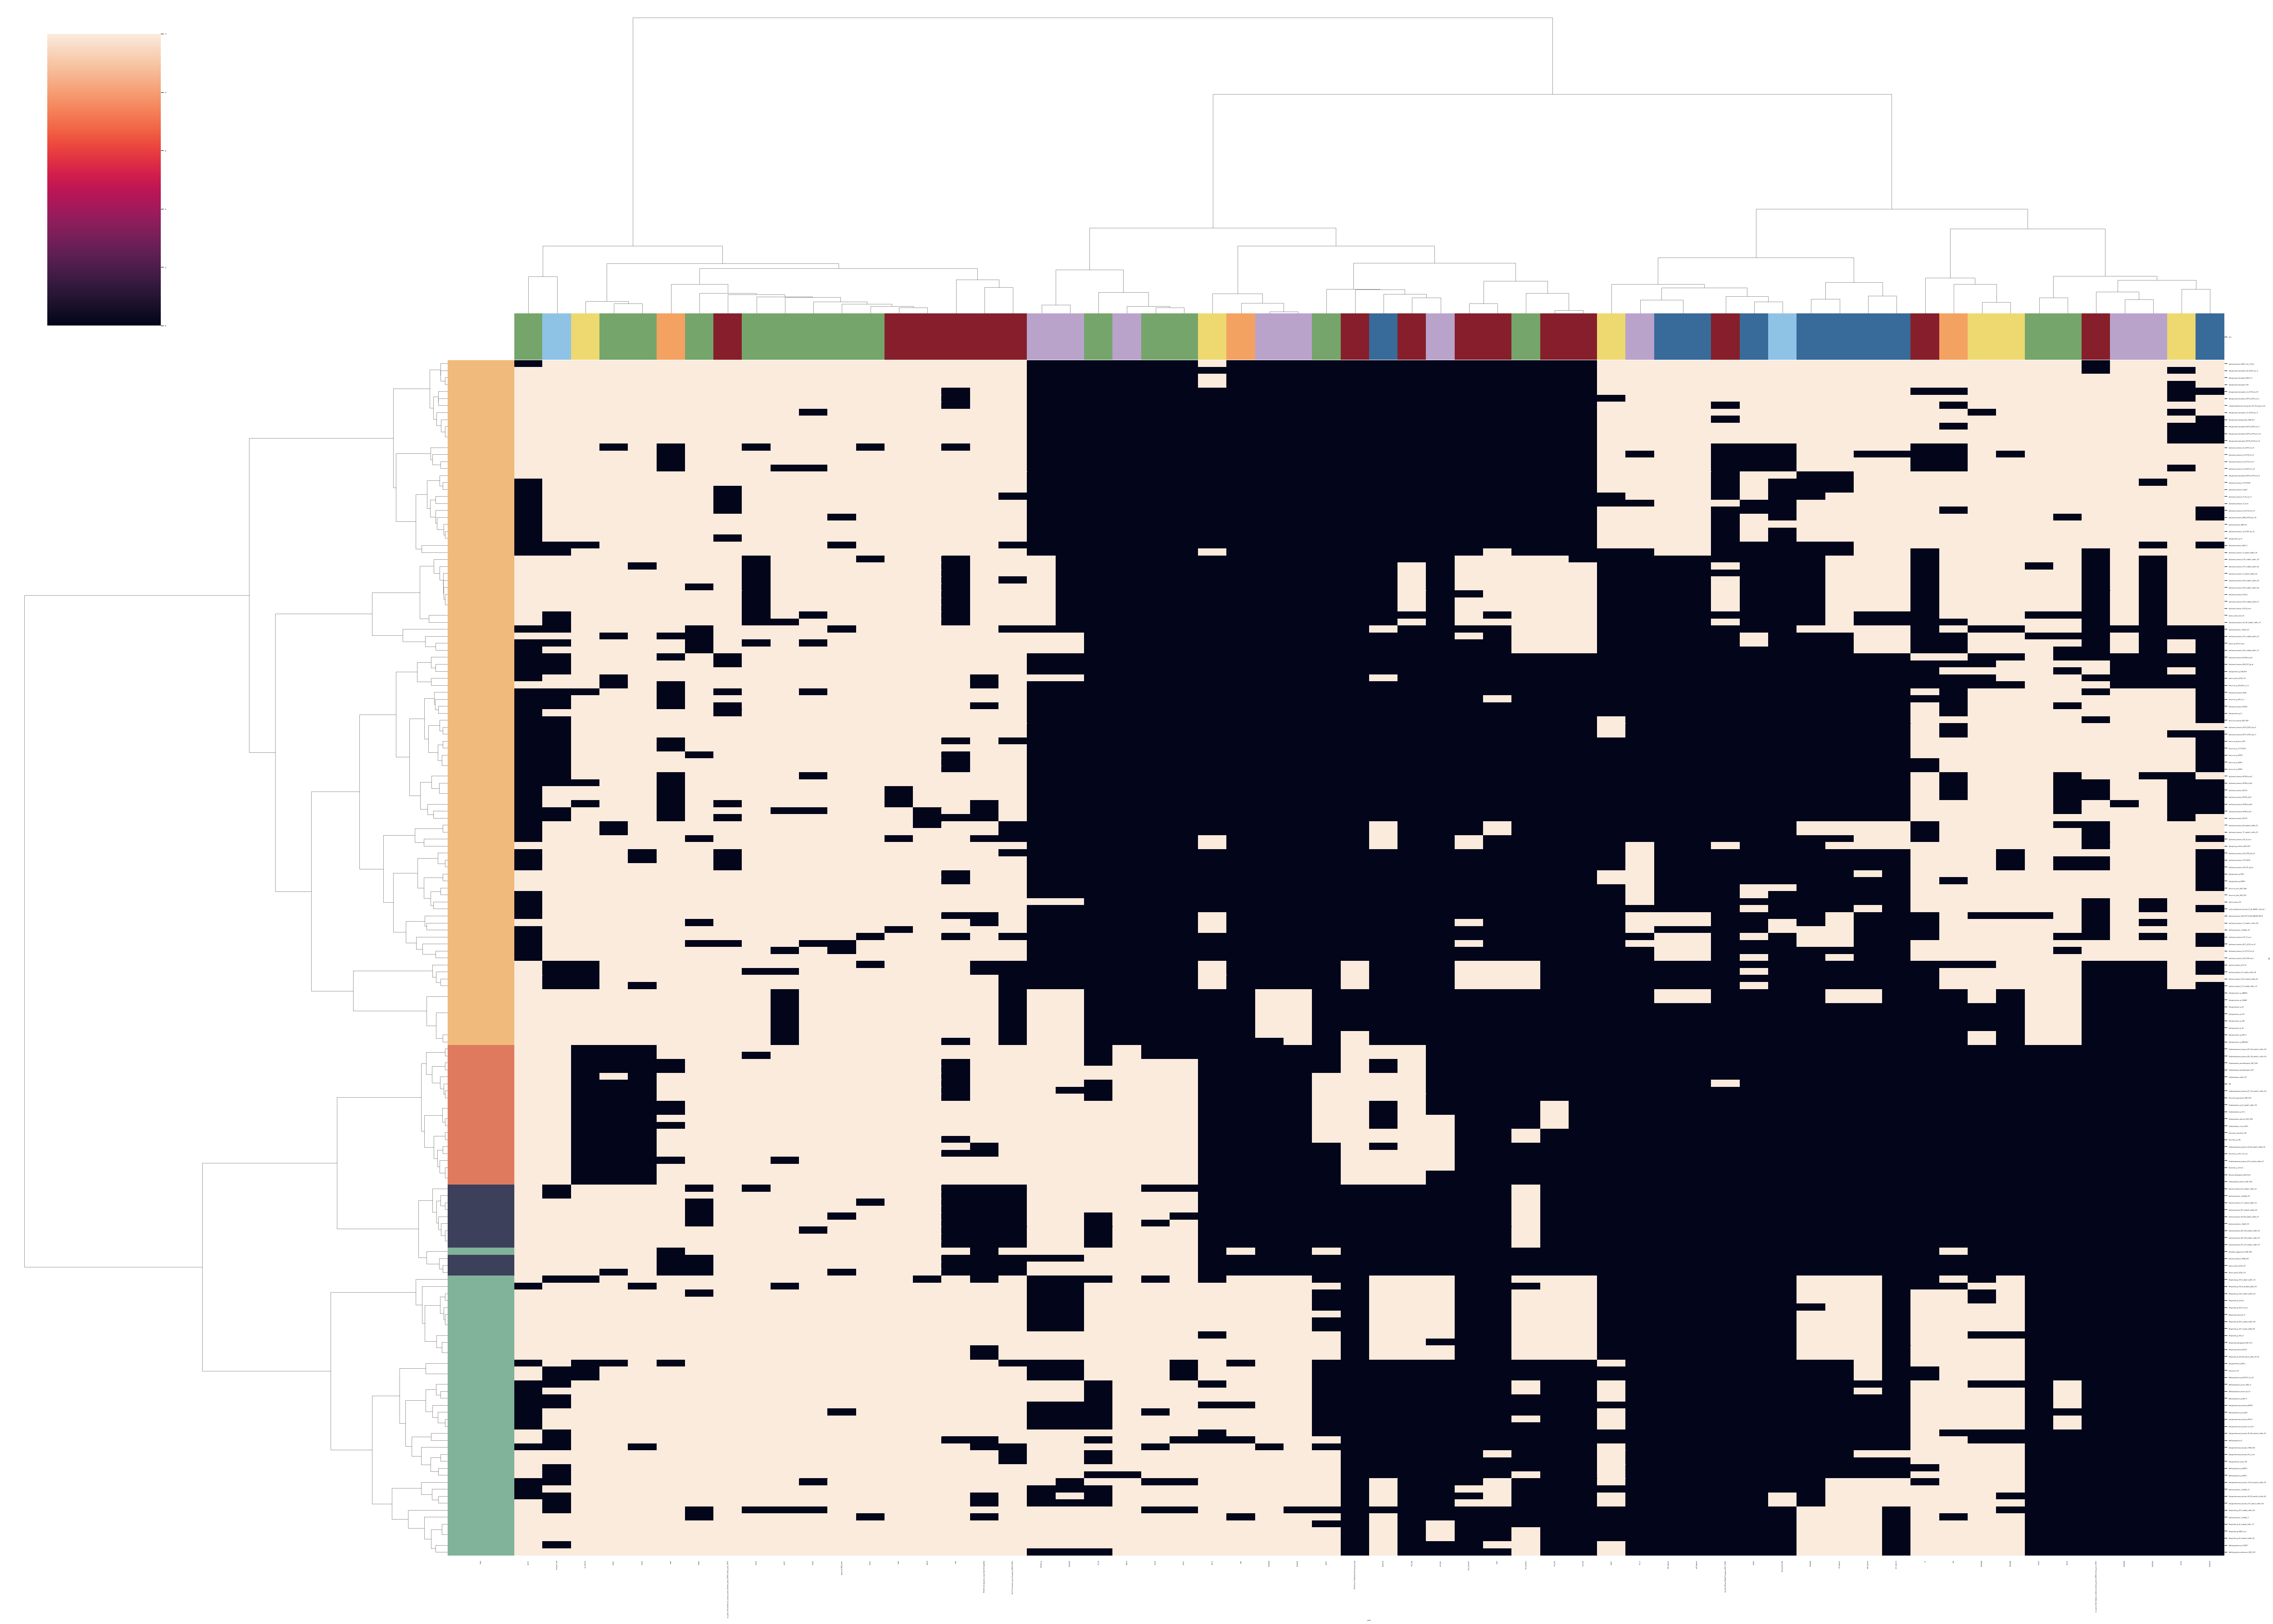

In [30]:
# Select columns that contain less that a proportion of zeroes
non_zero_columns = heat_df.columns[
    (heat_df == 0).mean() <= ABSENCE_THR
]
heat_df_nonzero = heat_df[non_zero_columns]

clustermap(
    data=heat_df_nonzero,
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-nonzero.svg"
    ),
    dpi=300
)

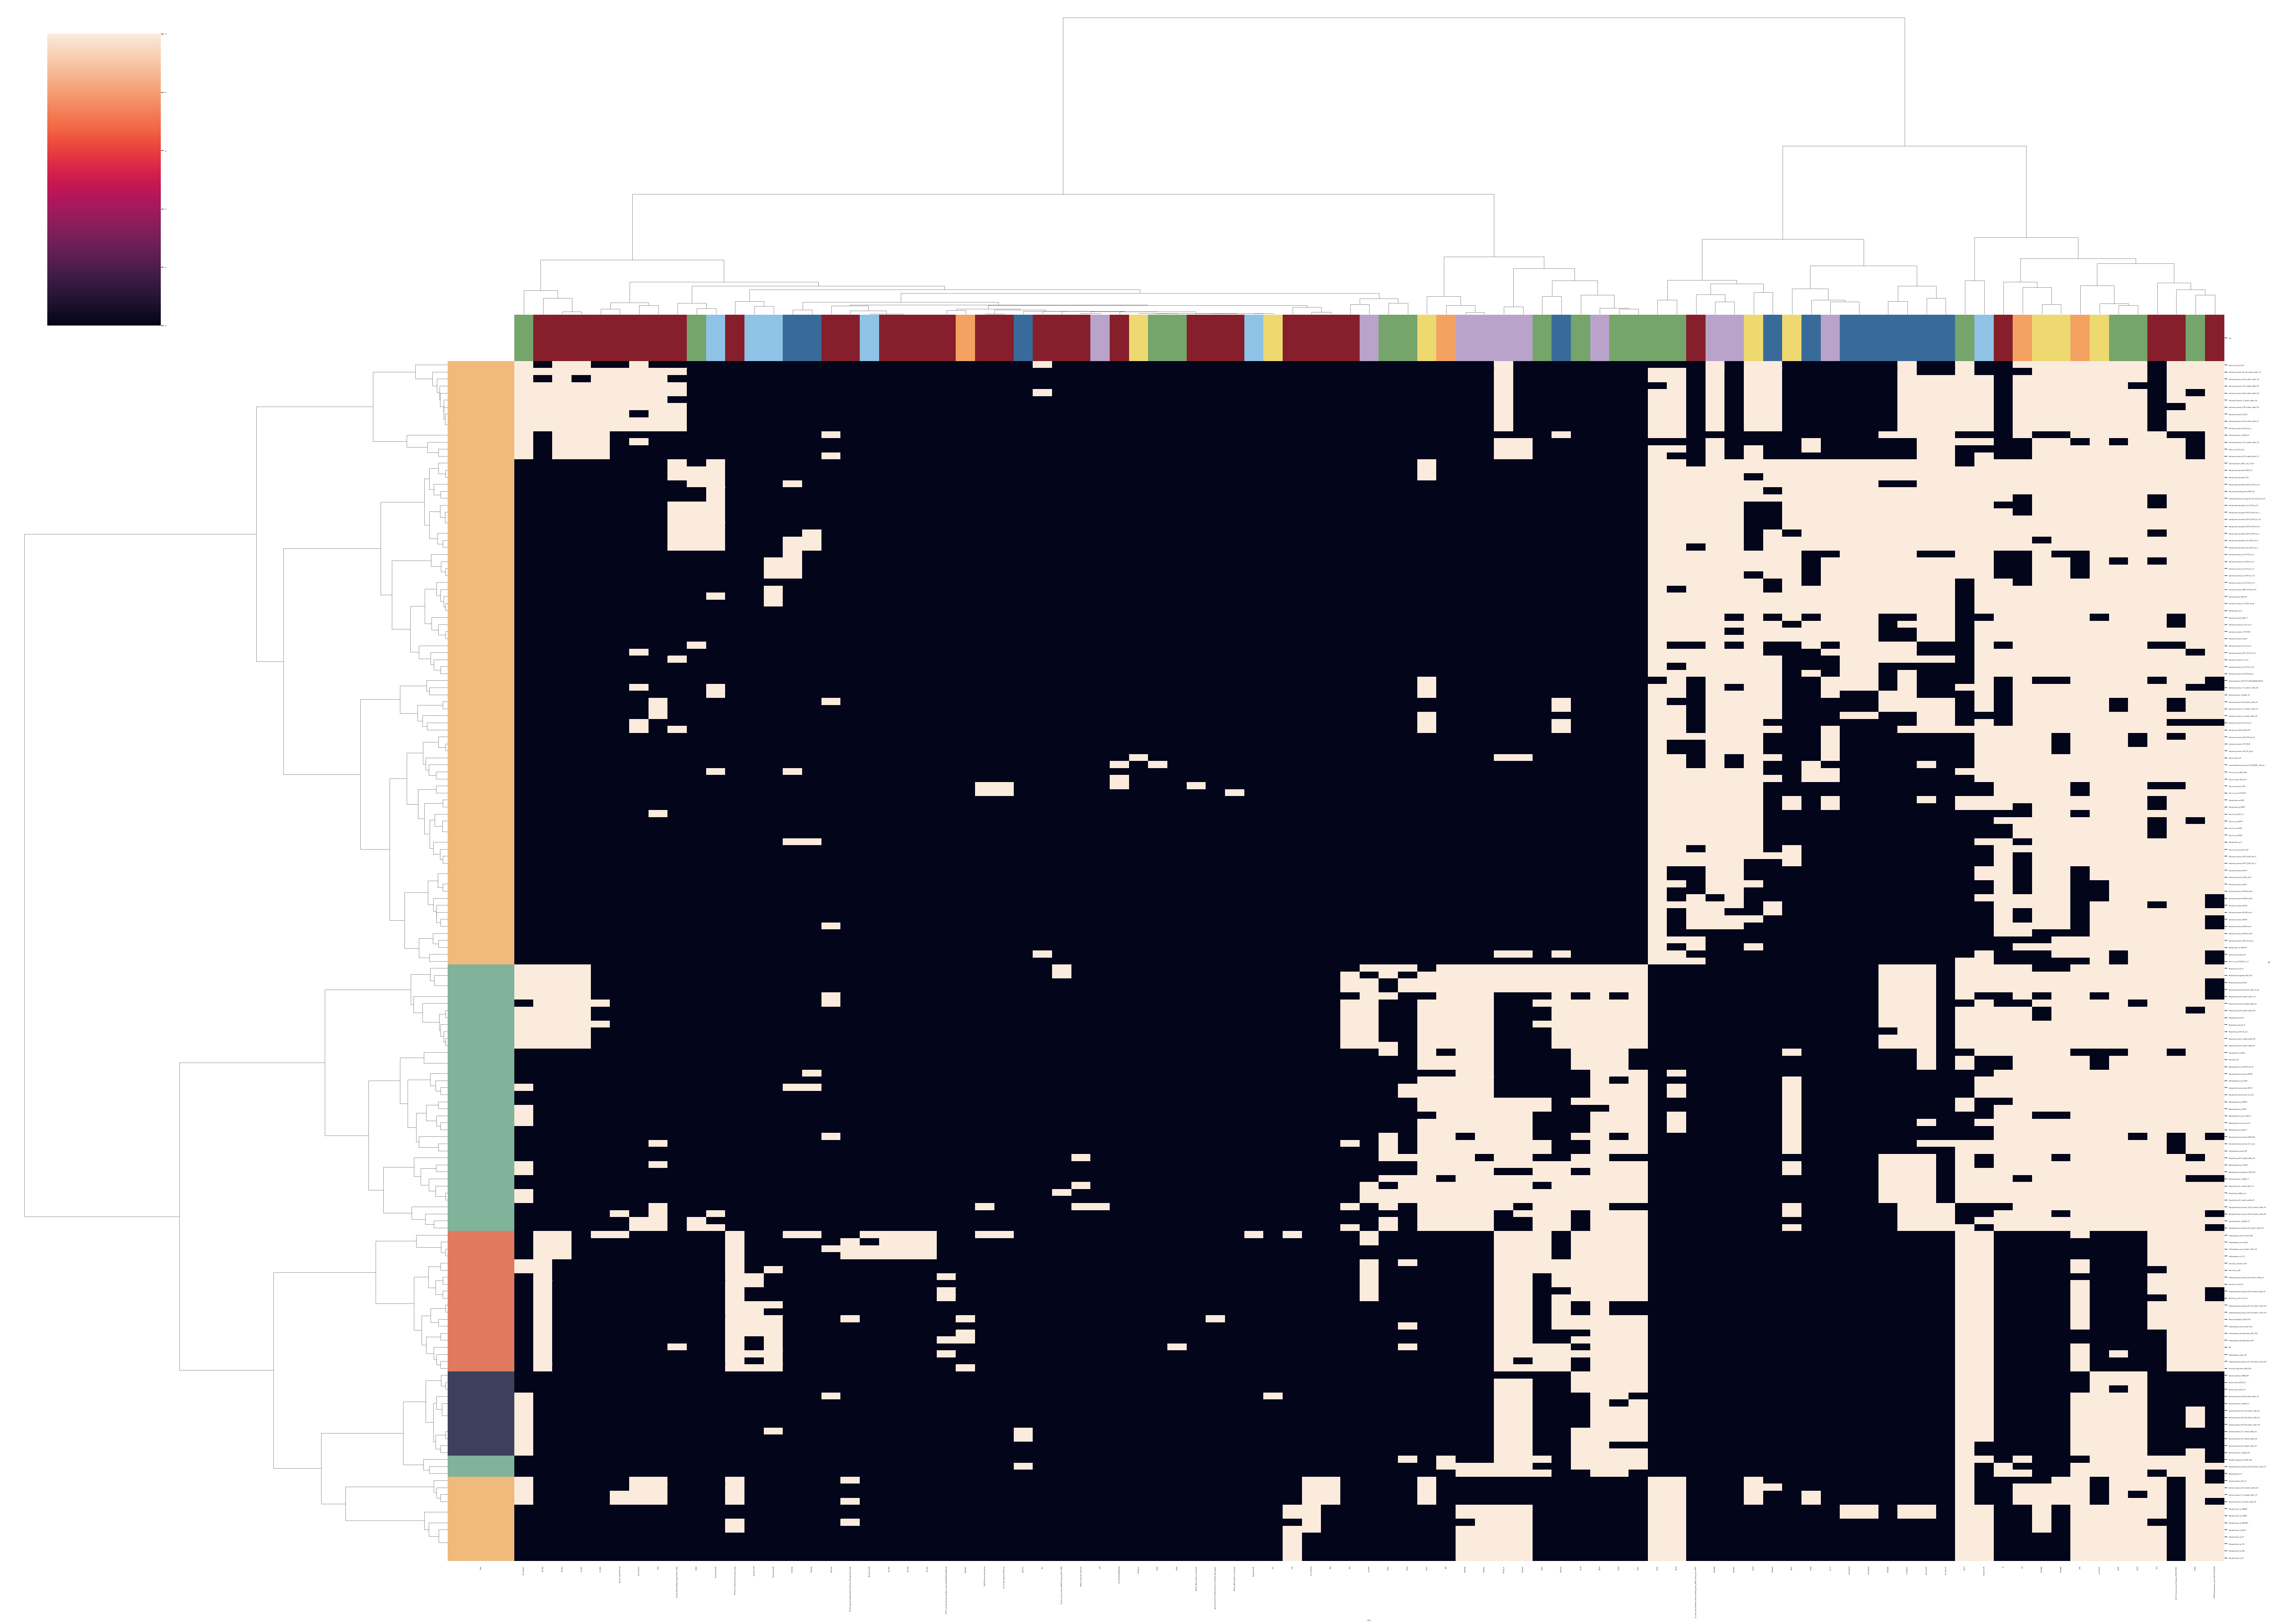

In [41]:
clustermap(
    data=heat_df.drop(core_hmms["hmm_model"].tolist(), axis=1),
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-accessory.svg"
    ),
    dpi=300
)

## Cycles clustermaps

[+] Clustermap for cycle Arsenic
[ERROR] Could not create clustermap for cycle Arsenic: index 0 is out of bounds for axis 0 with size 0
[+] Clustermap for cycle Carbon


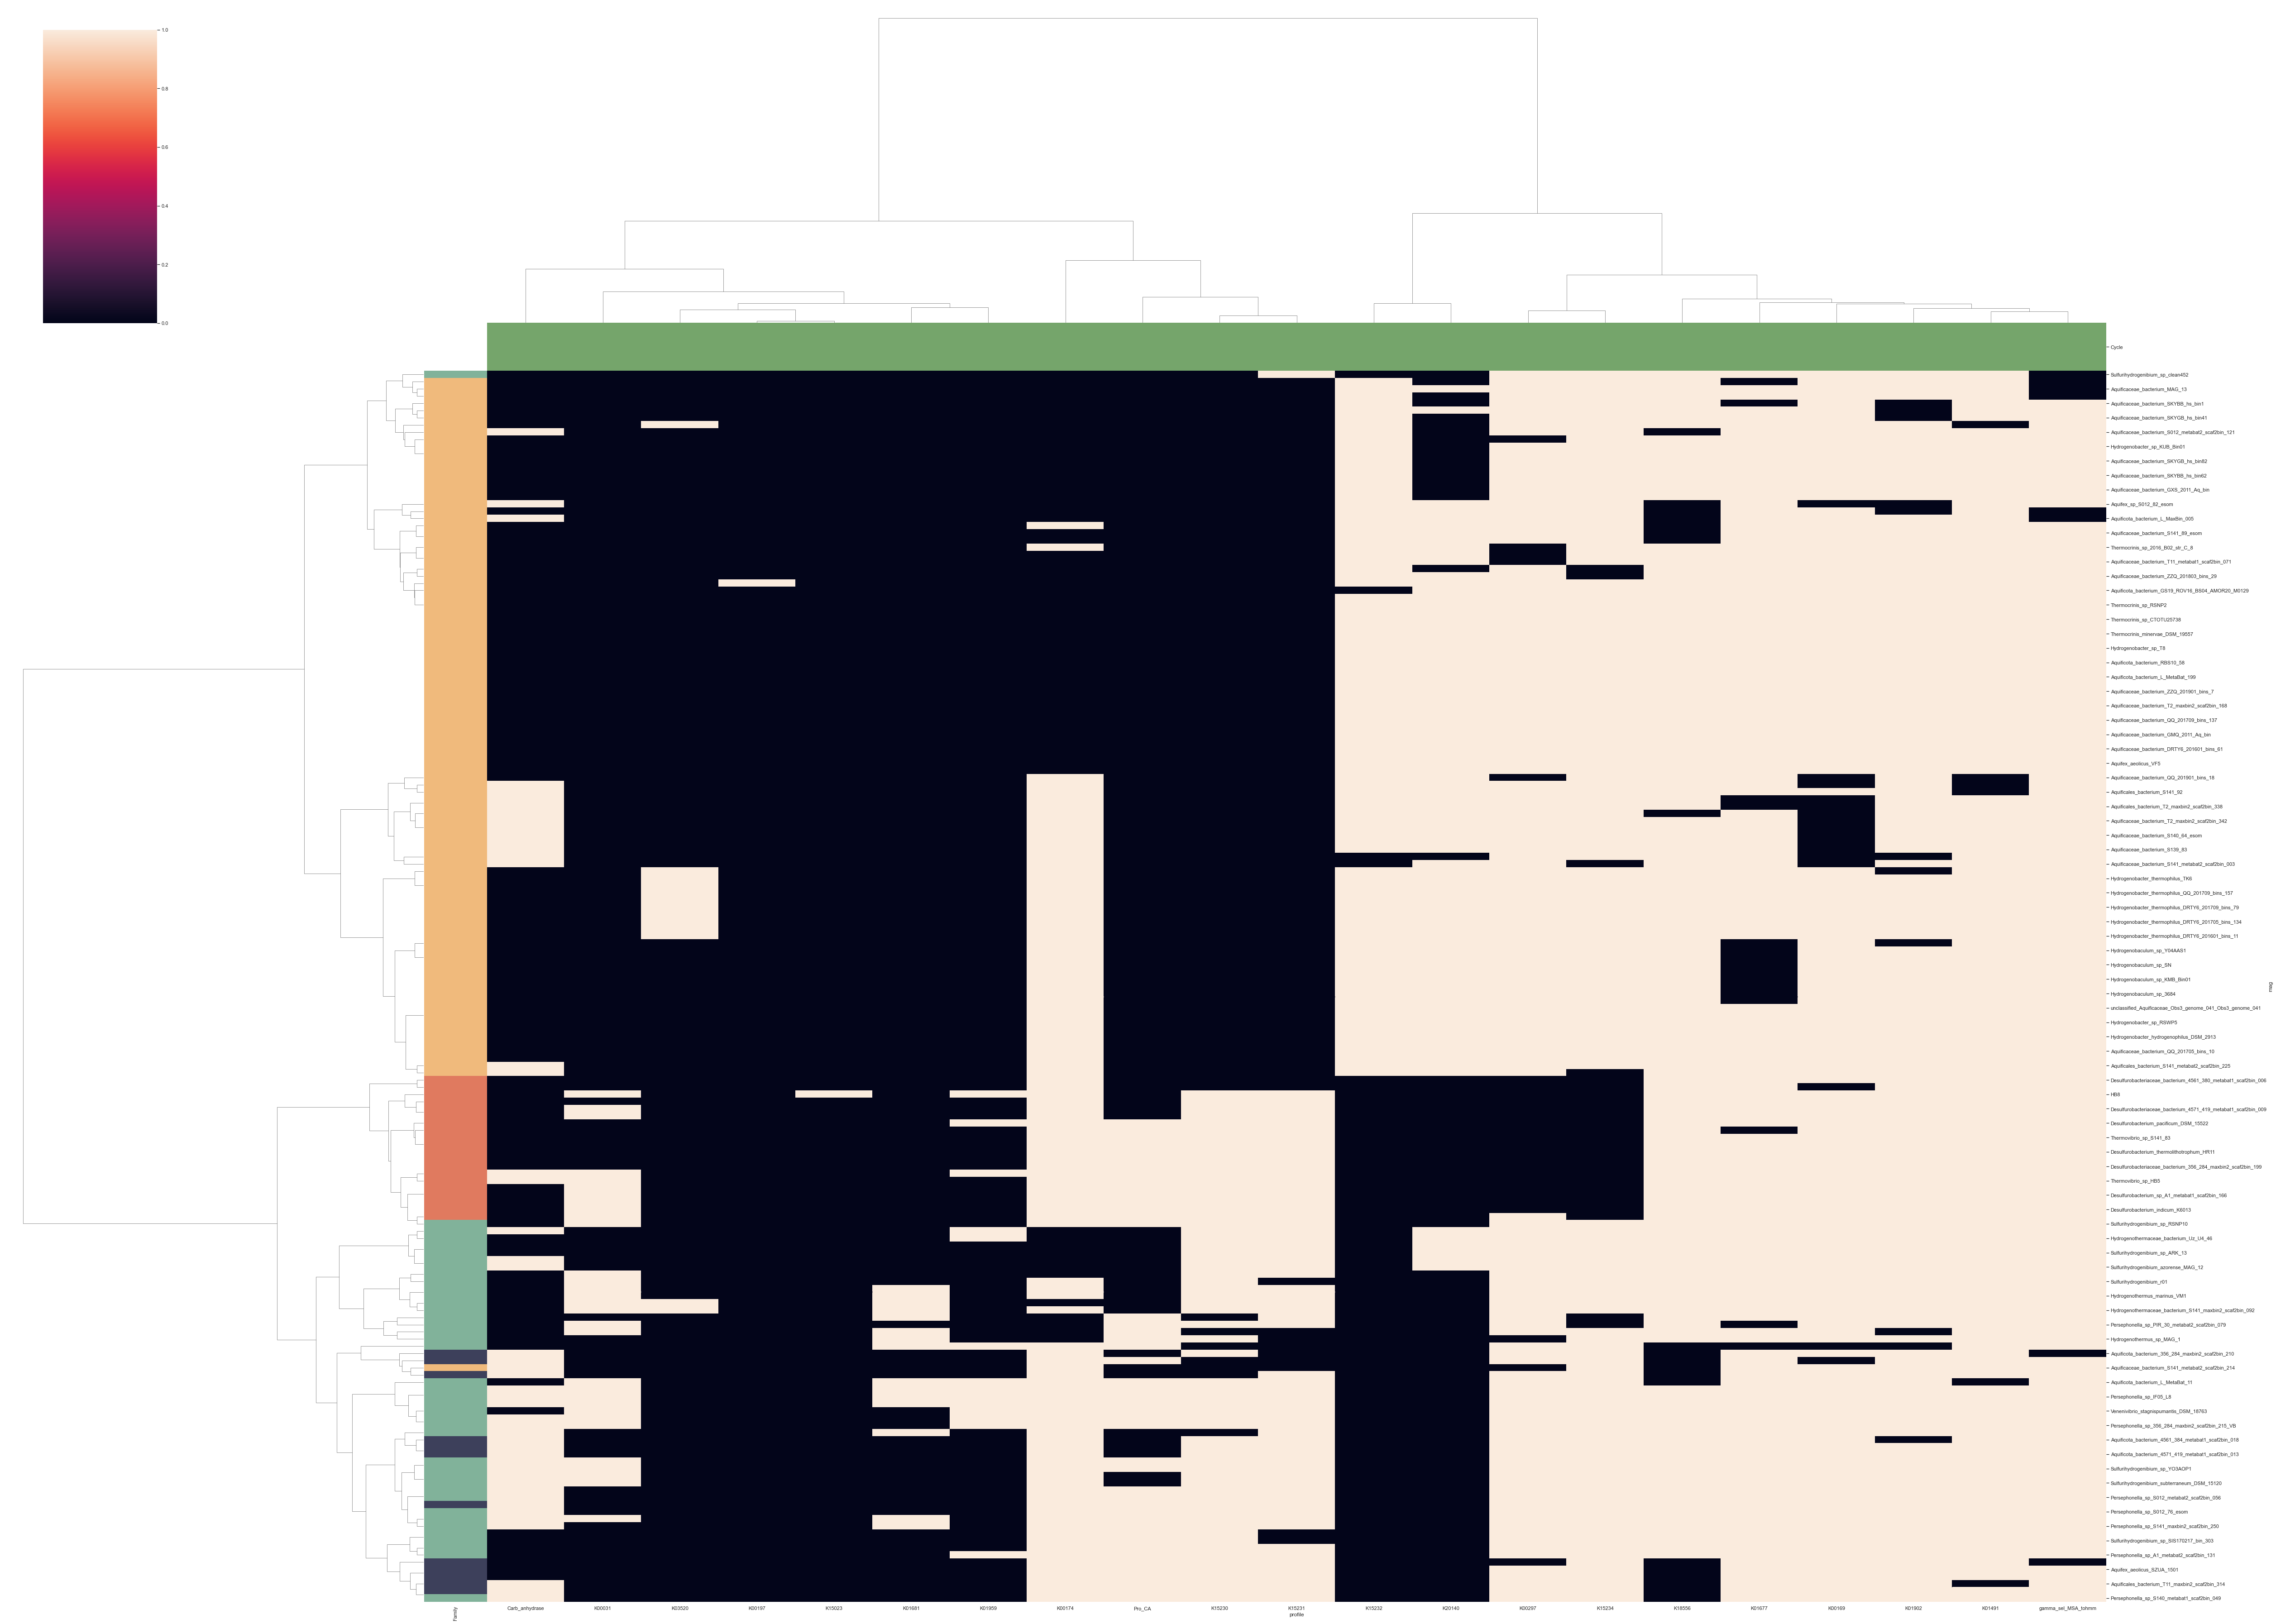

[+] Clustermap for cycle Methane
[ERROR] Could not create clustermap for cycle Methane: index 0 is out of bounds for axis 0 with size 0
[+] Clustermap for cycle Nitrogen


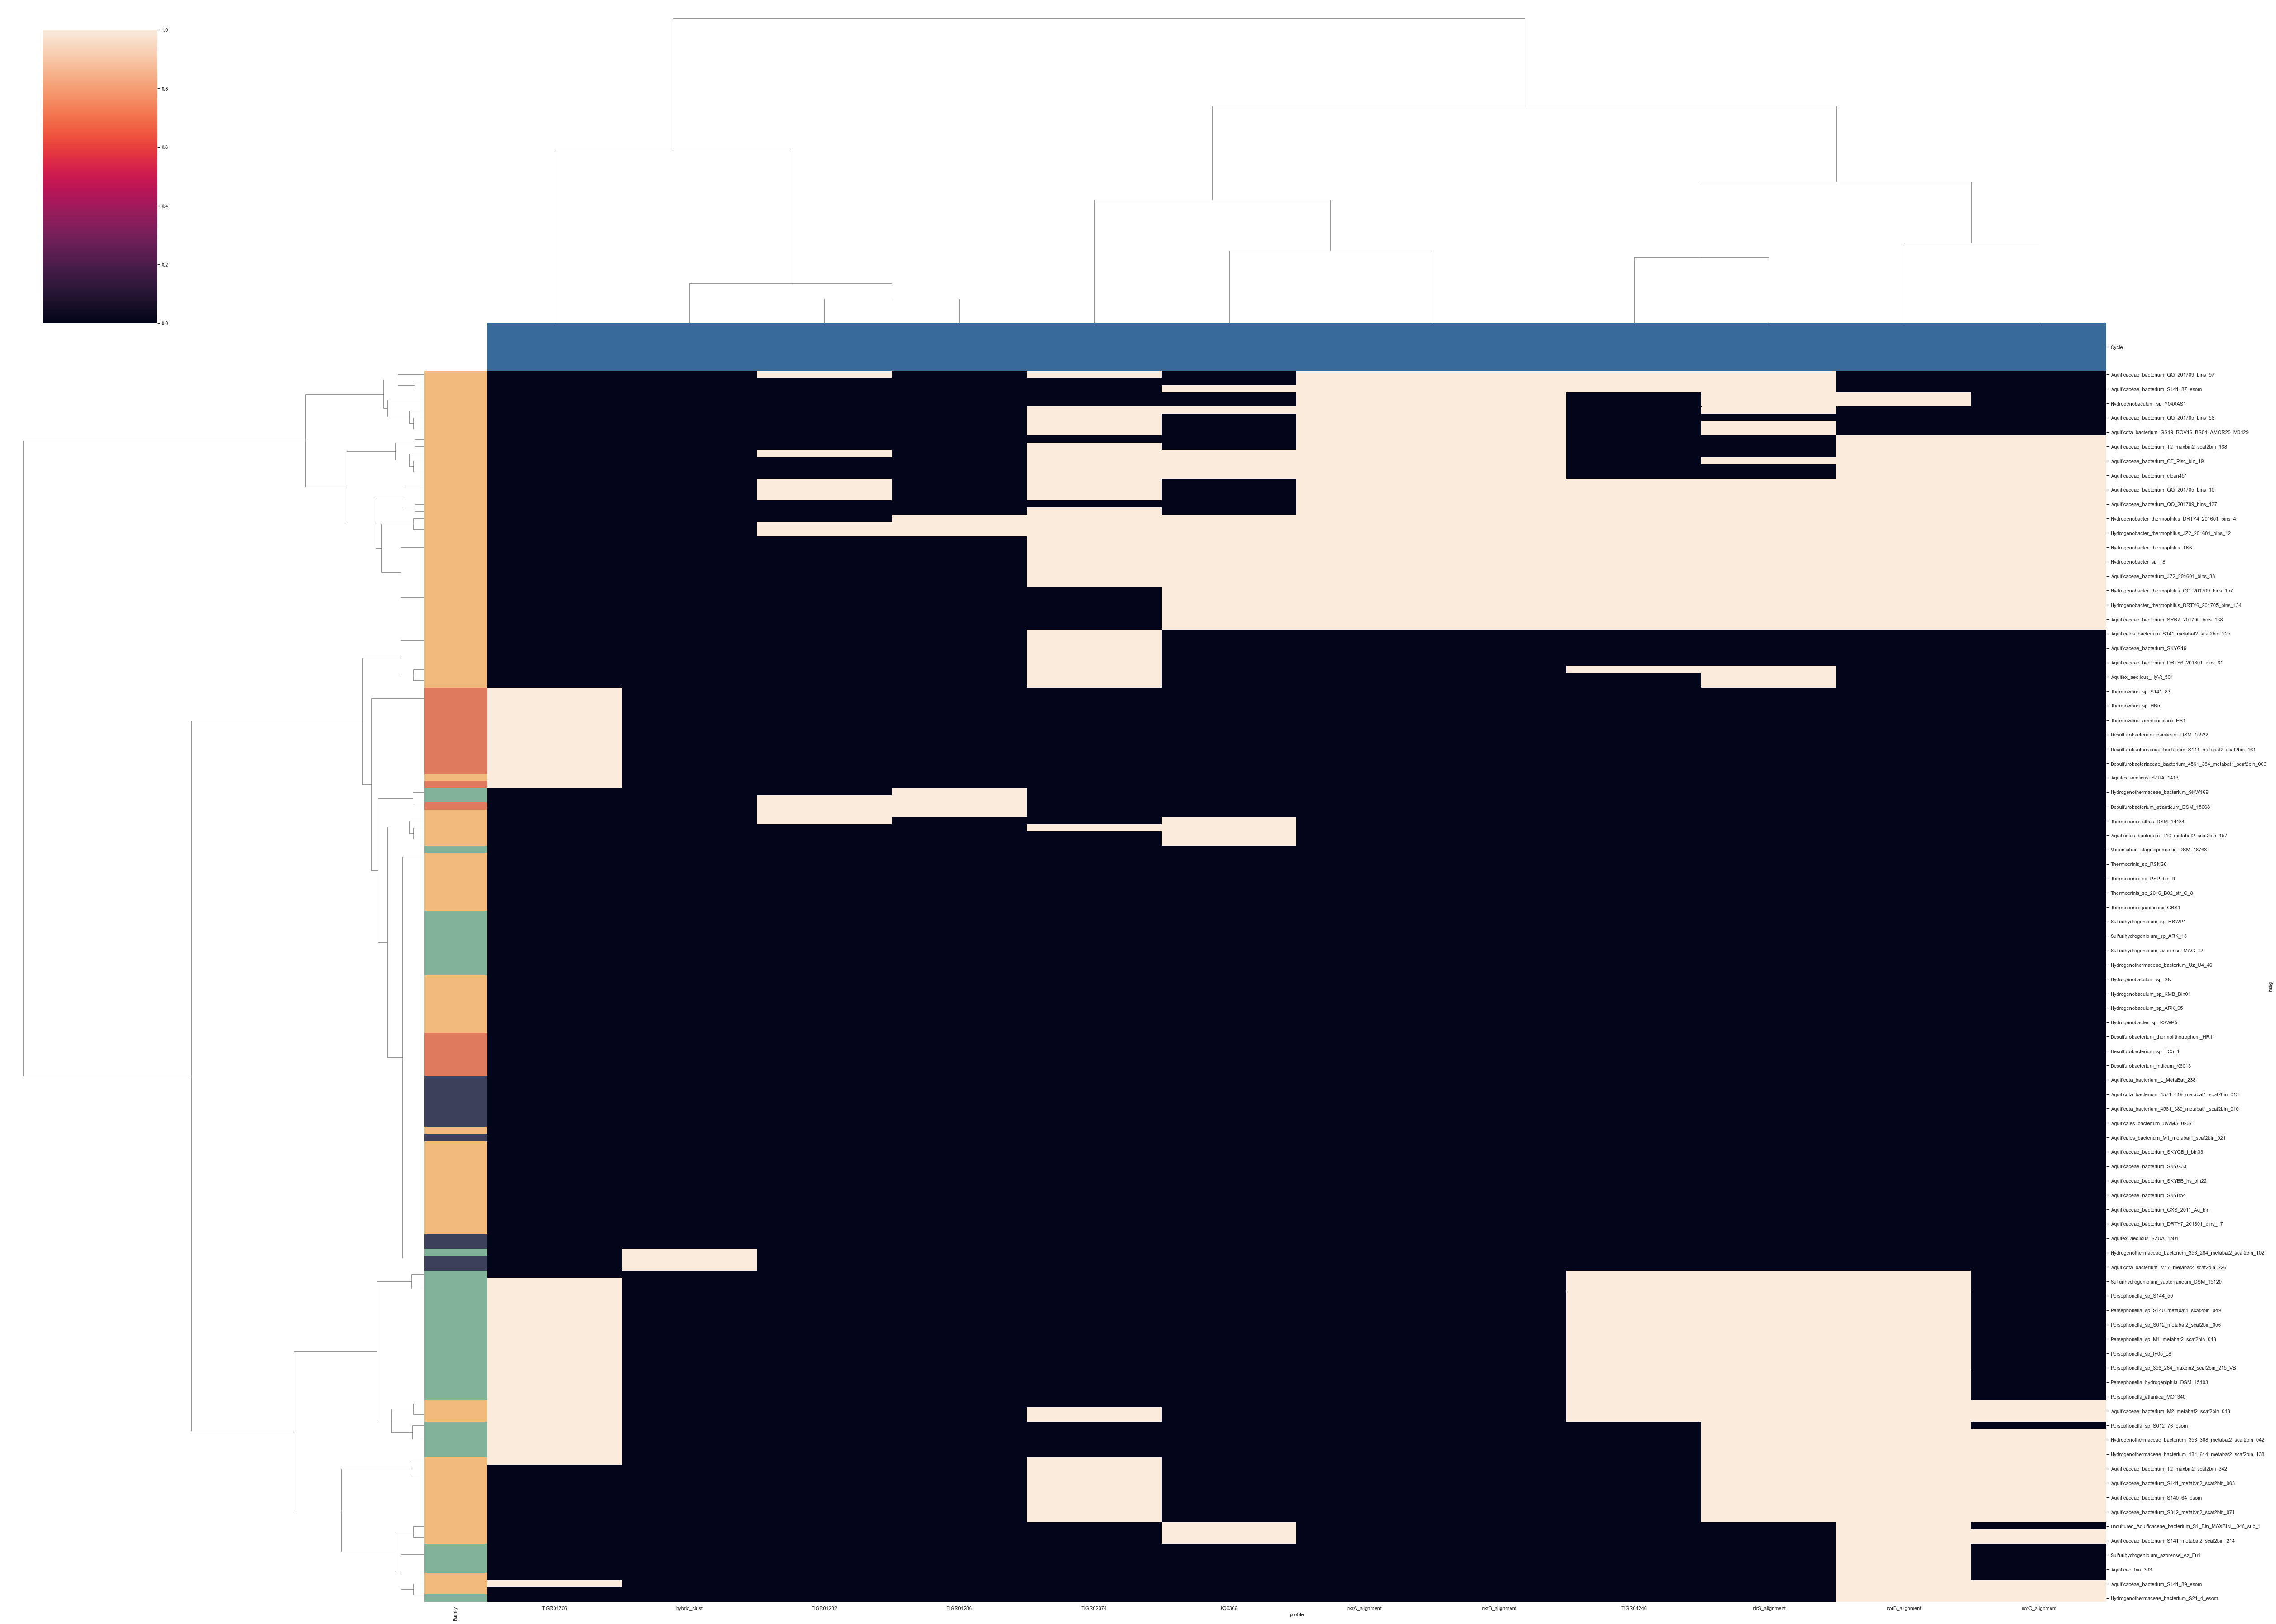

[+] Clustermap for cycle Oxygen


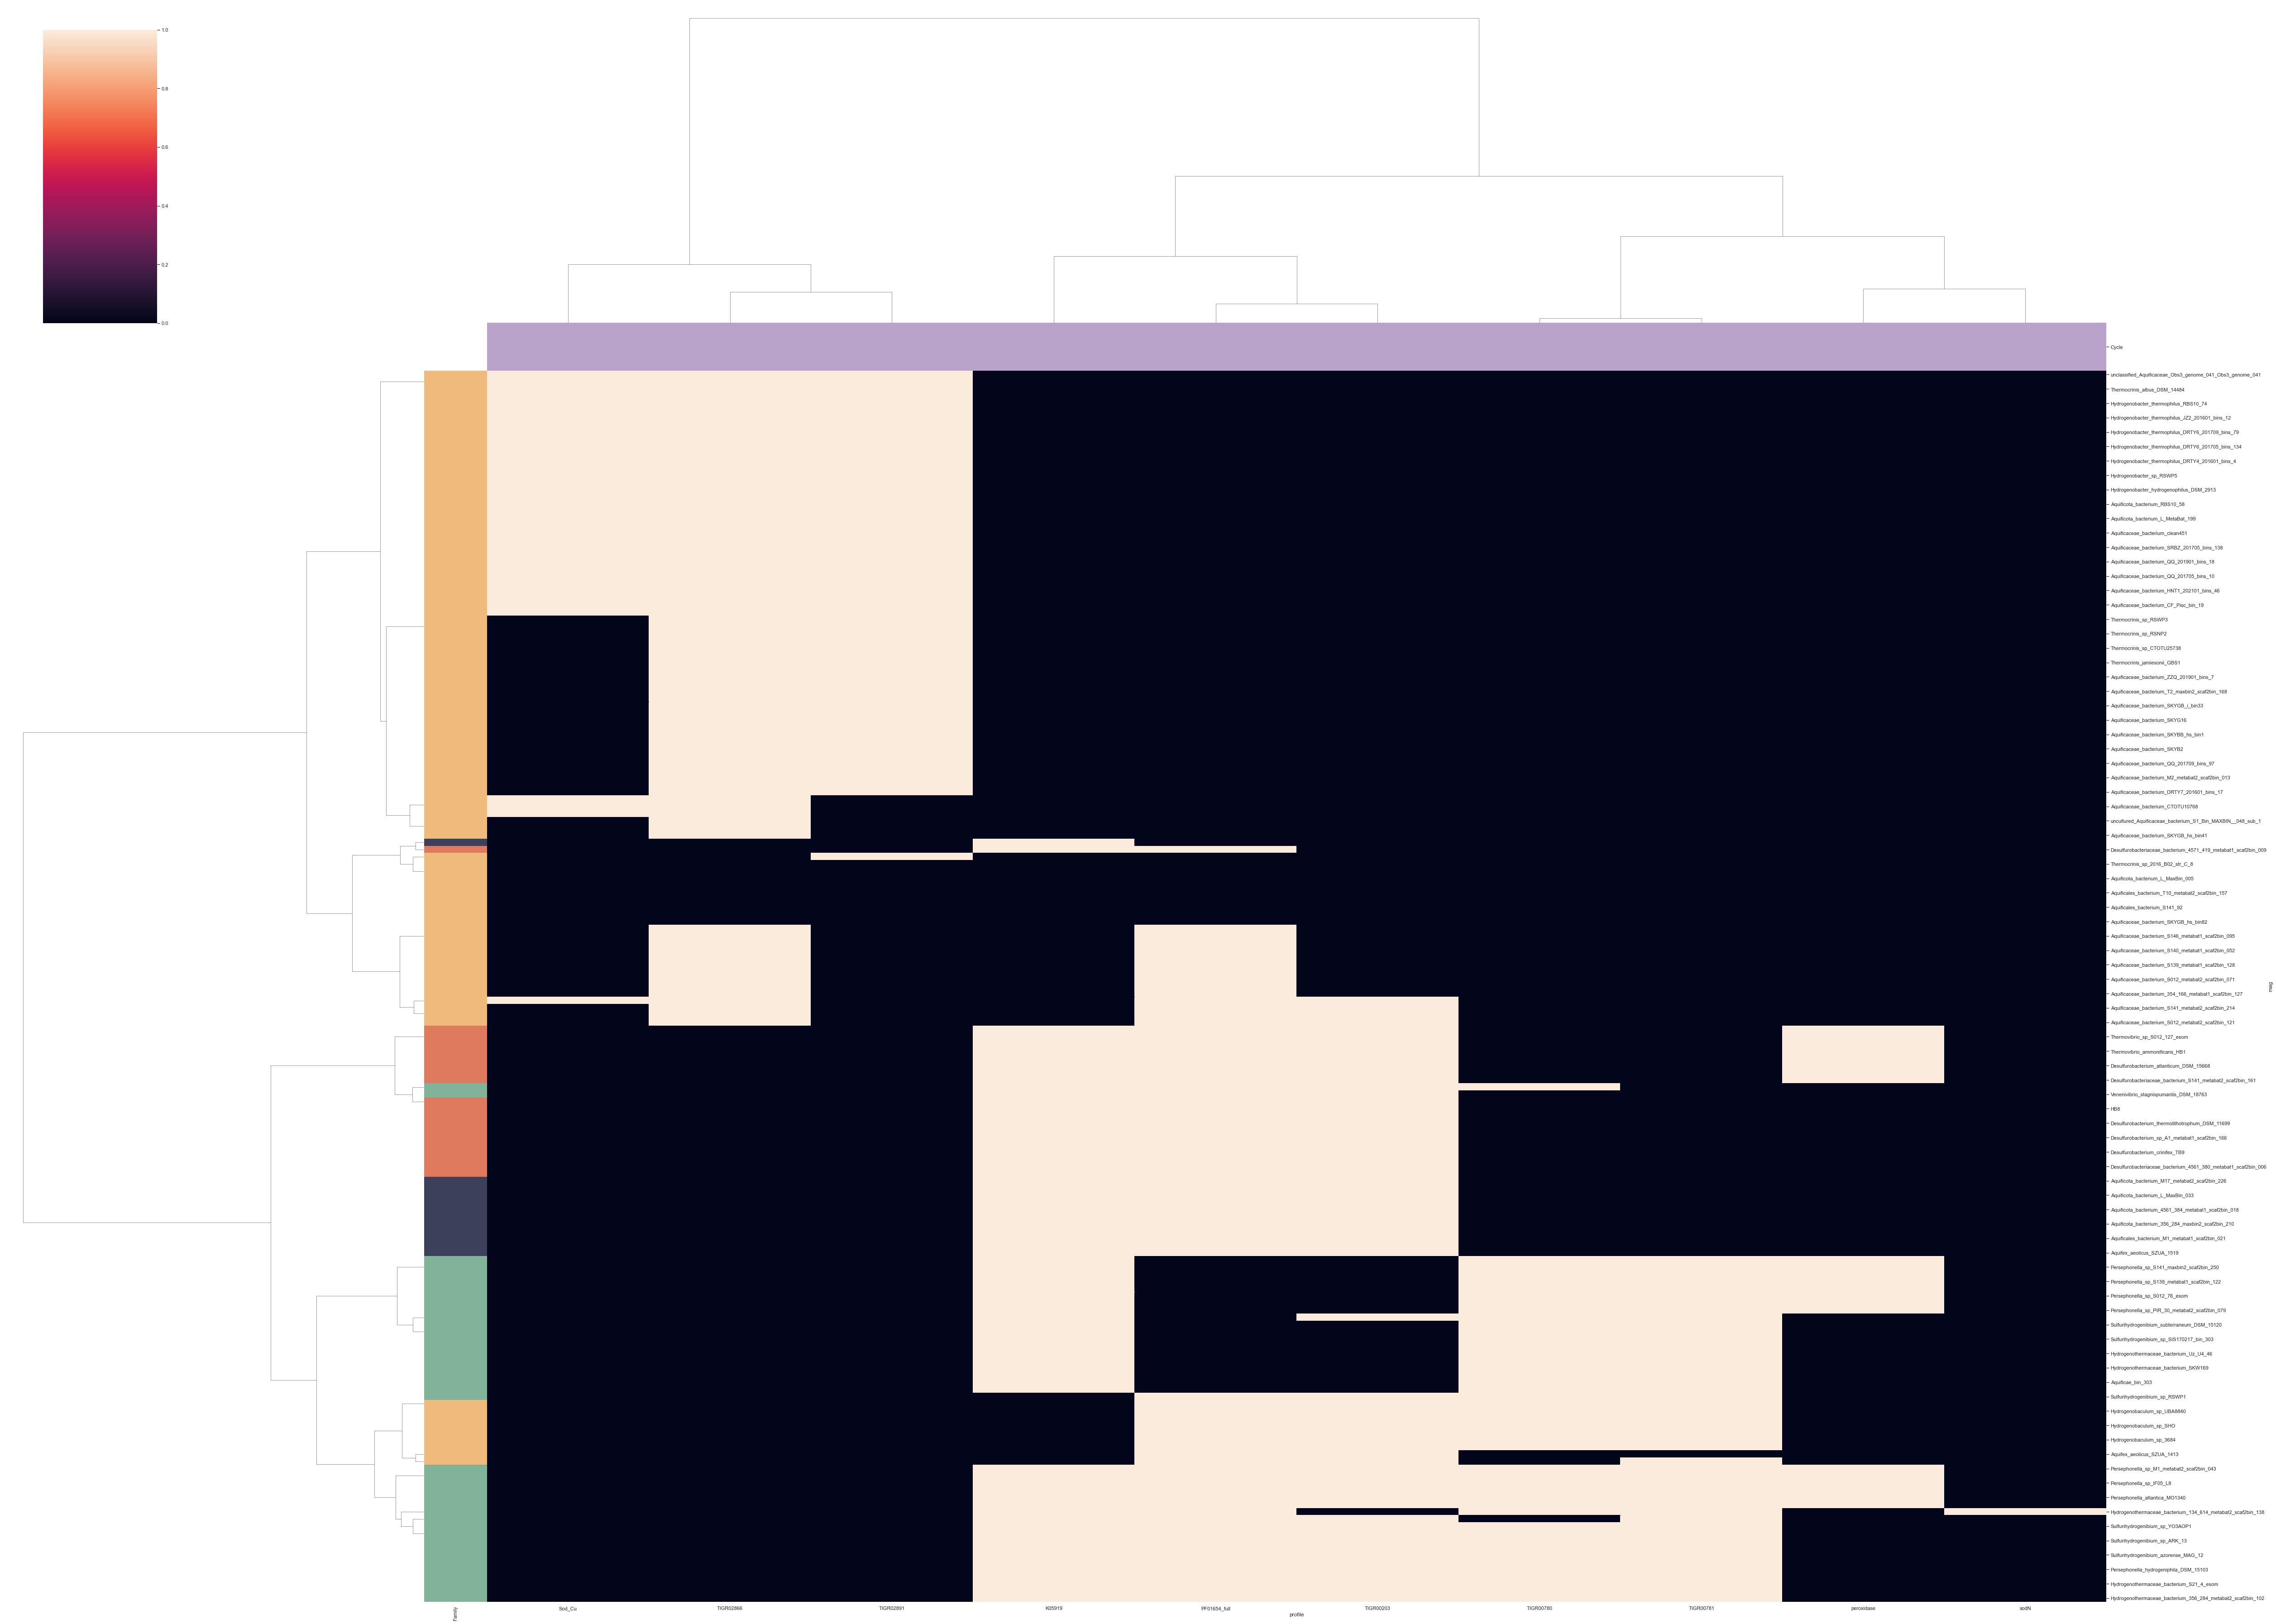

[+] Clustermap for cycle Photosynthesis
[ERROR] Could not create clustermap for cycle Photosynthesis: index 0 is out of bounds for axis 0 with size 0
[+] Clustermap for cycle Sulfur


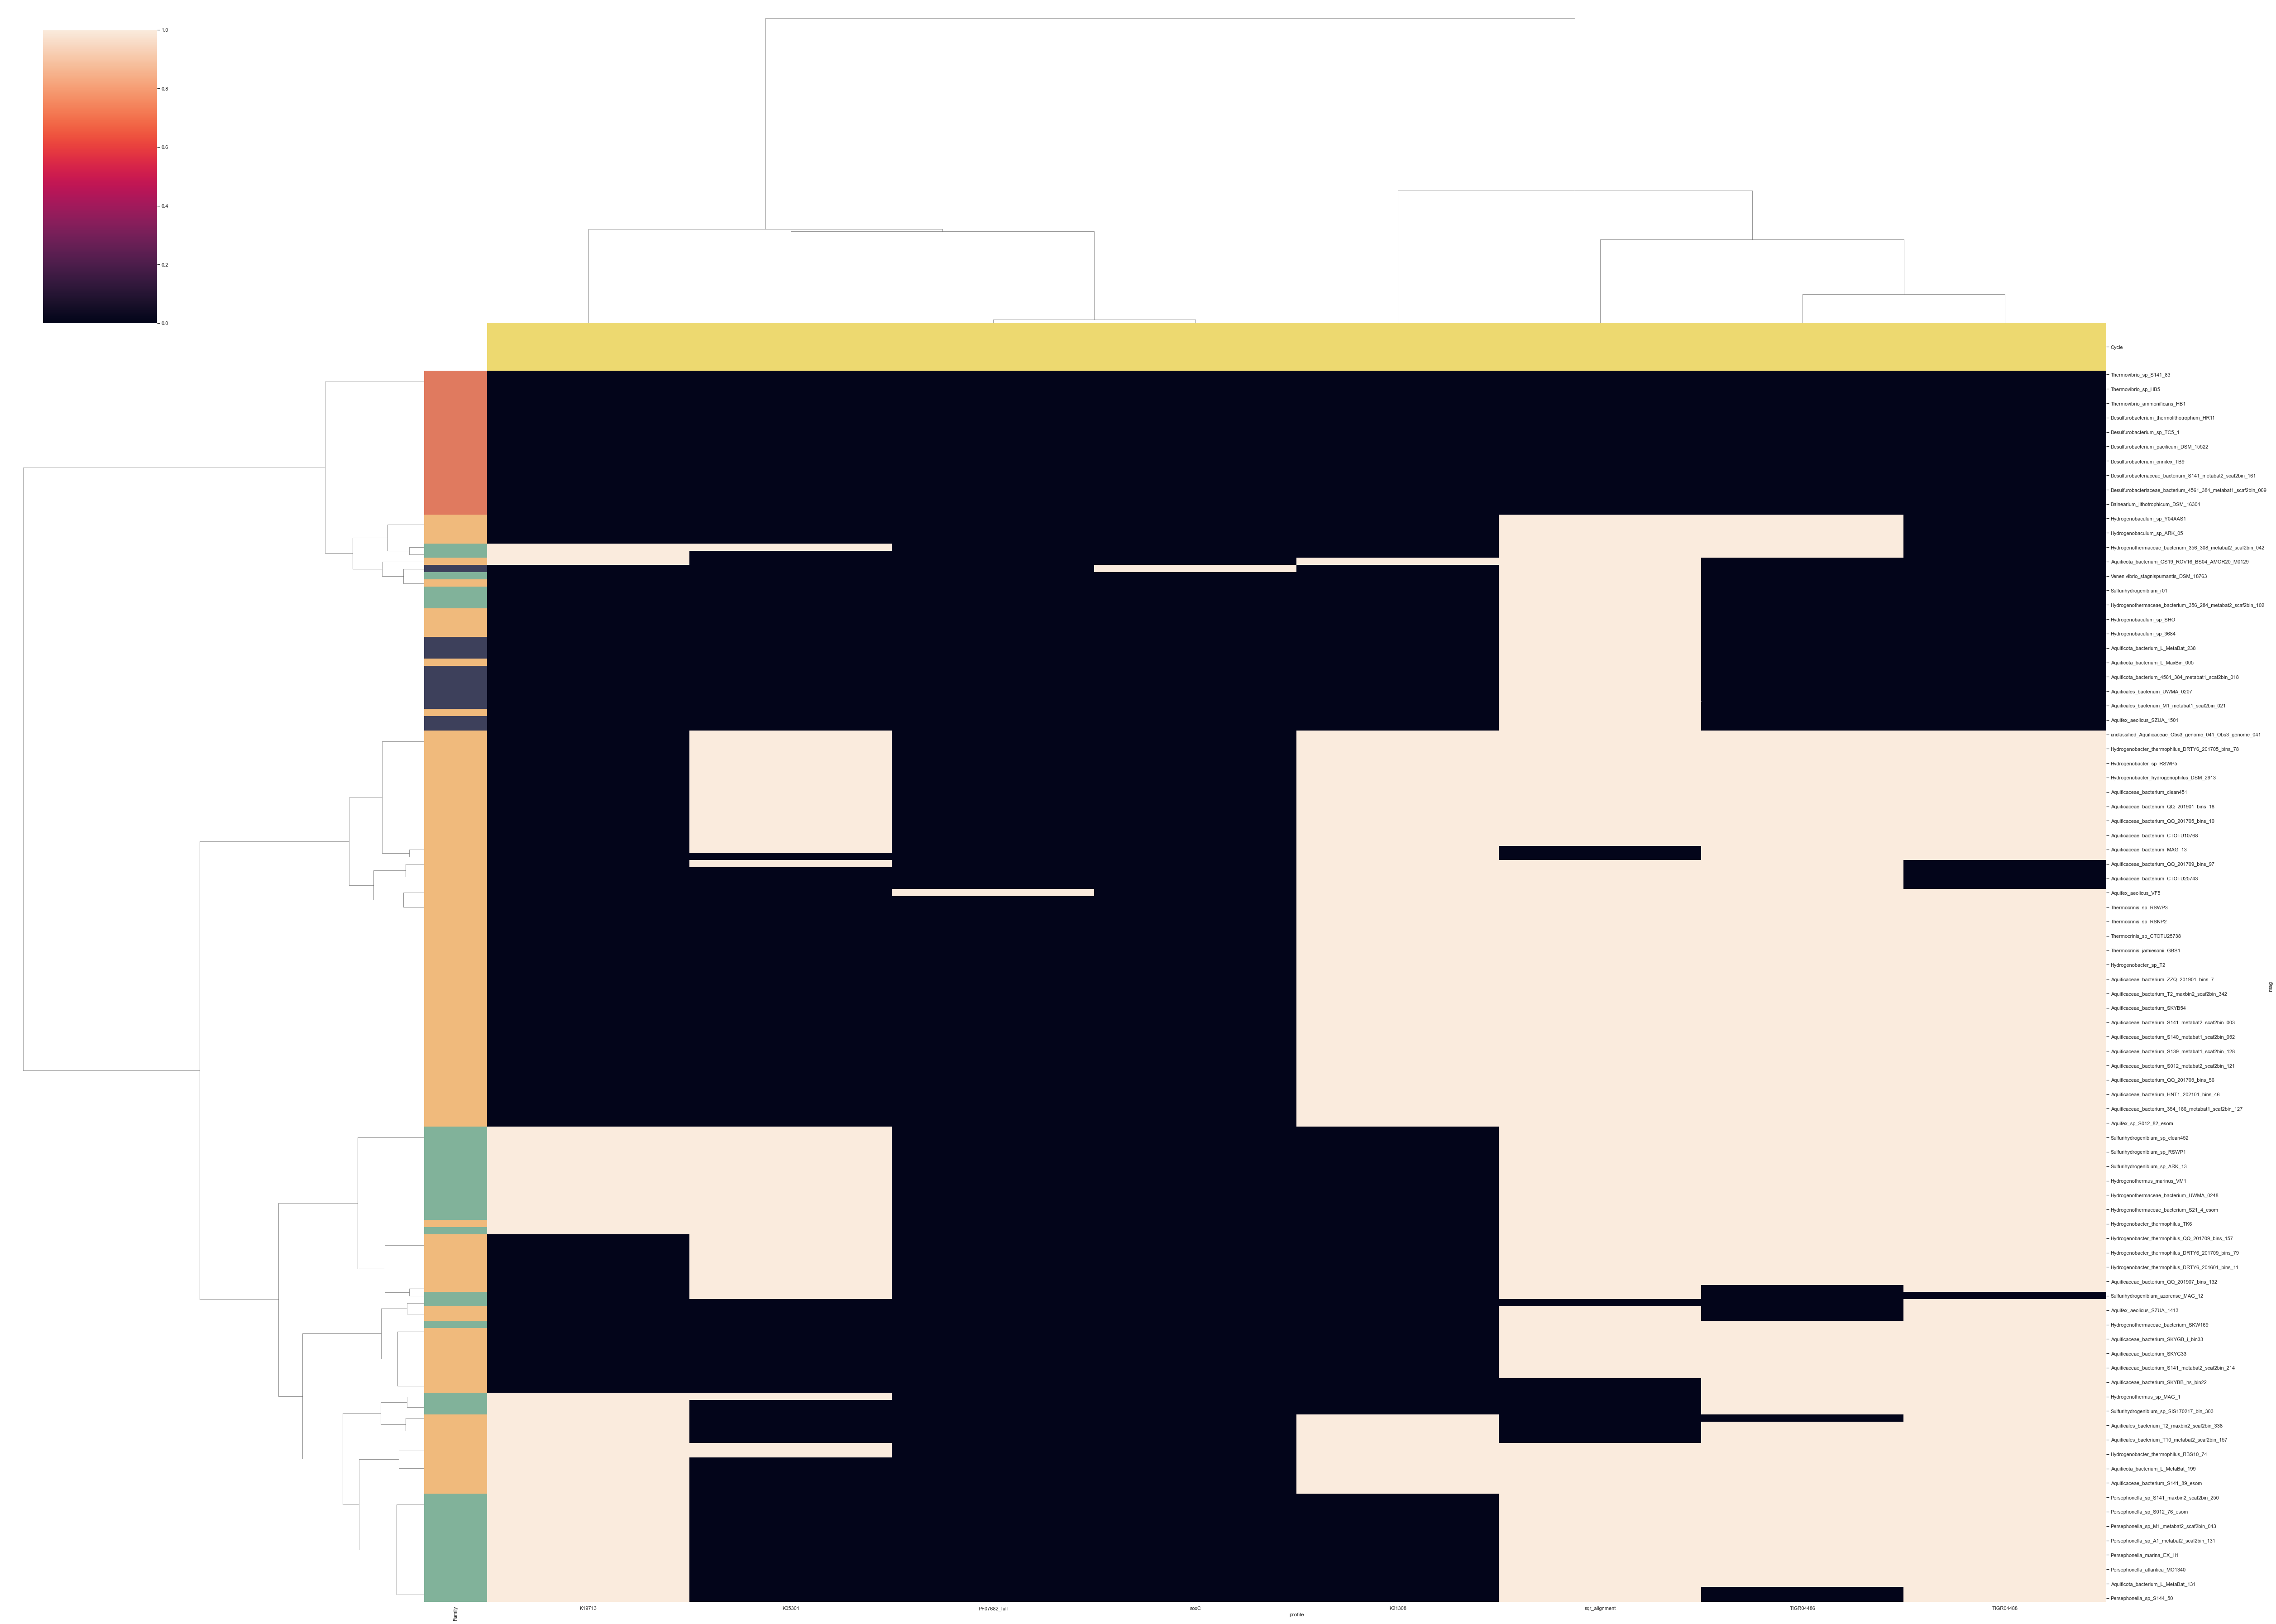

[+] Clustermap for cycle Transporters


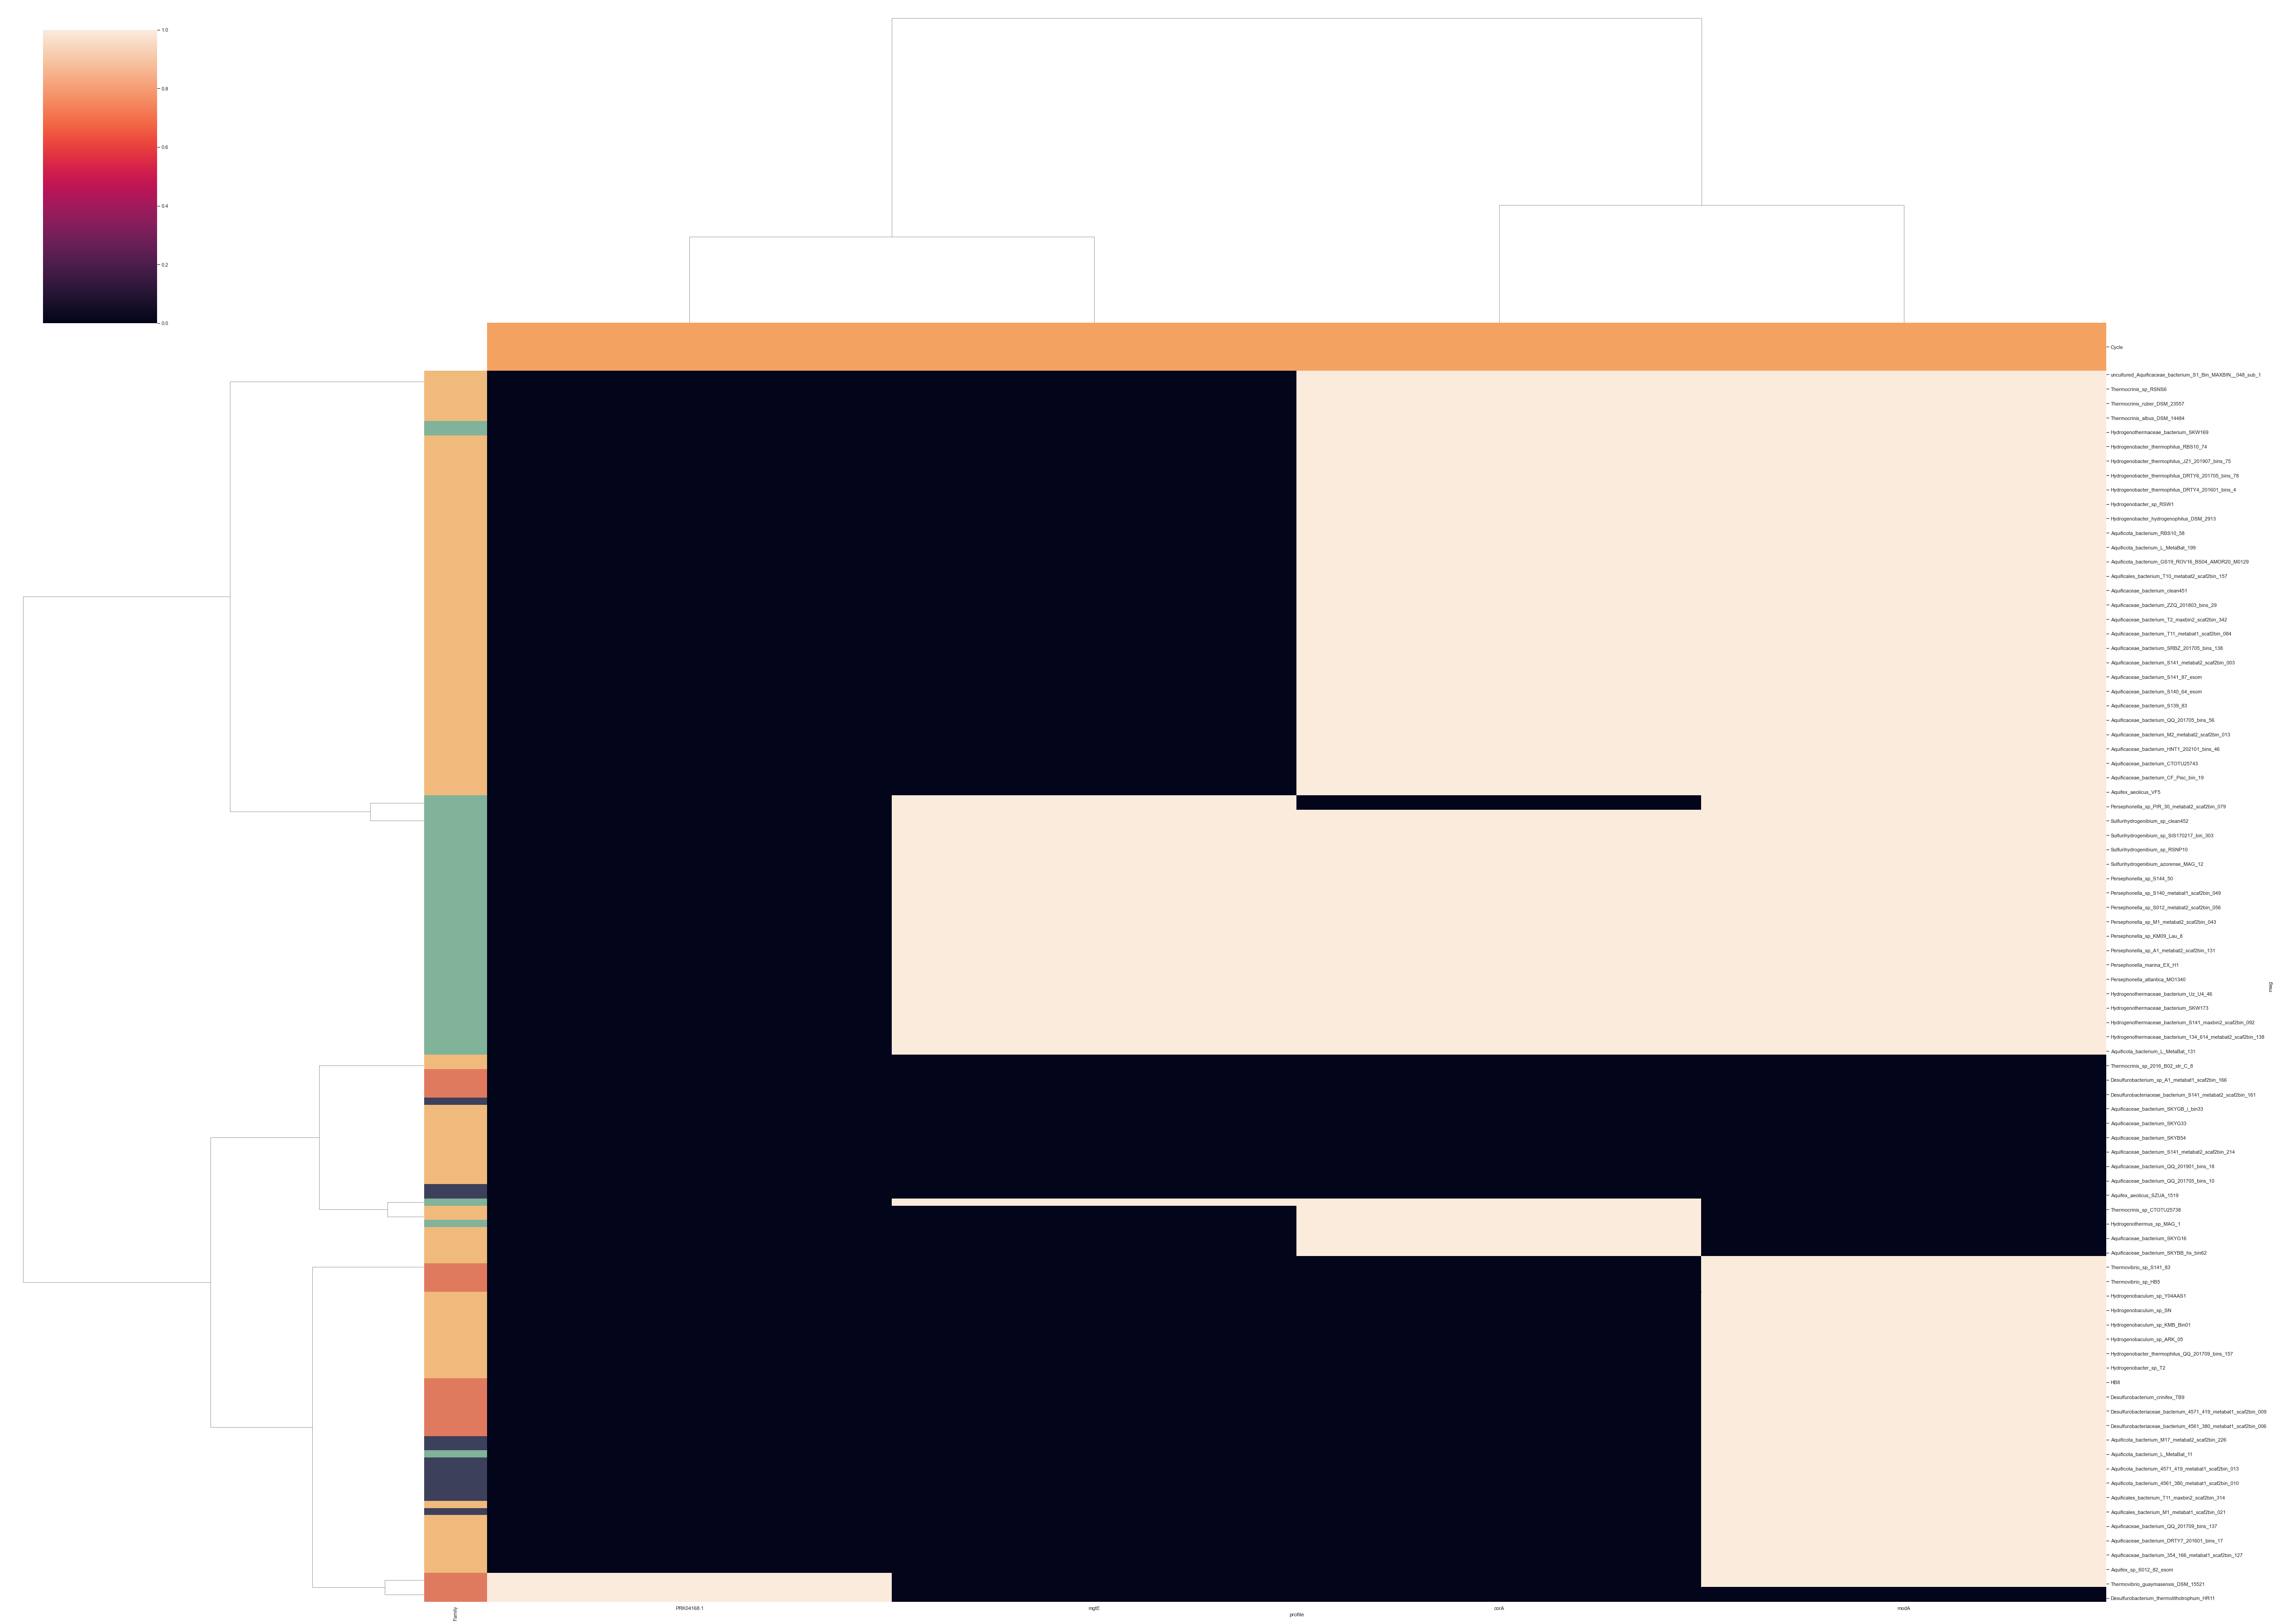

[+] Clustermap for cycle Hydrogen


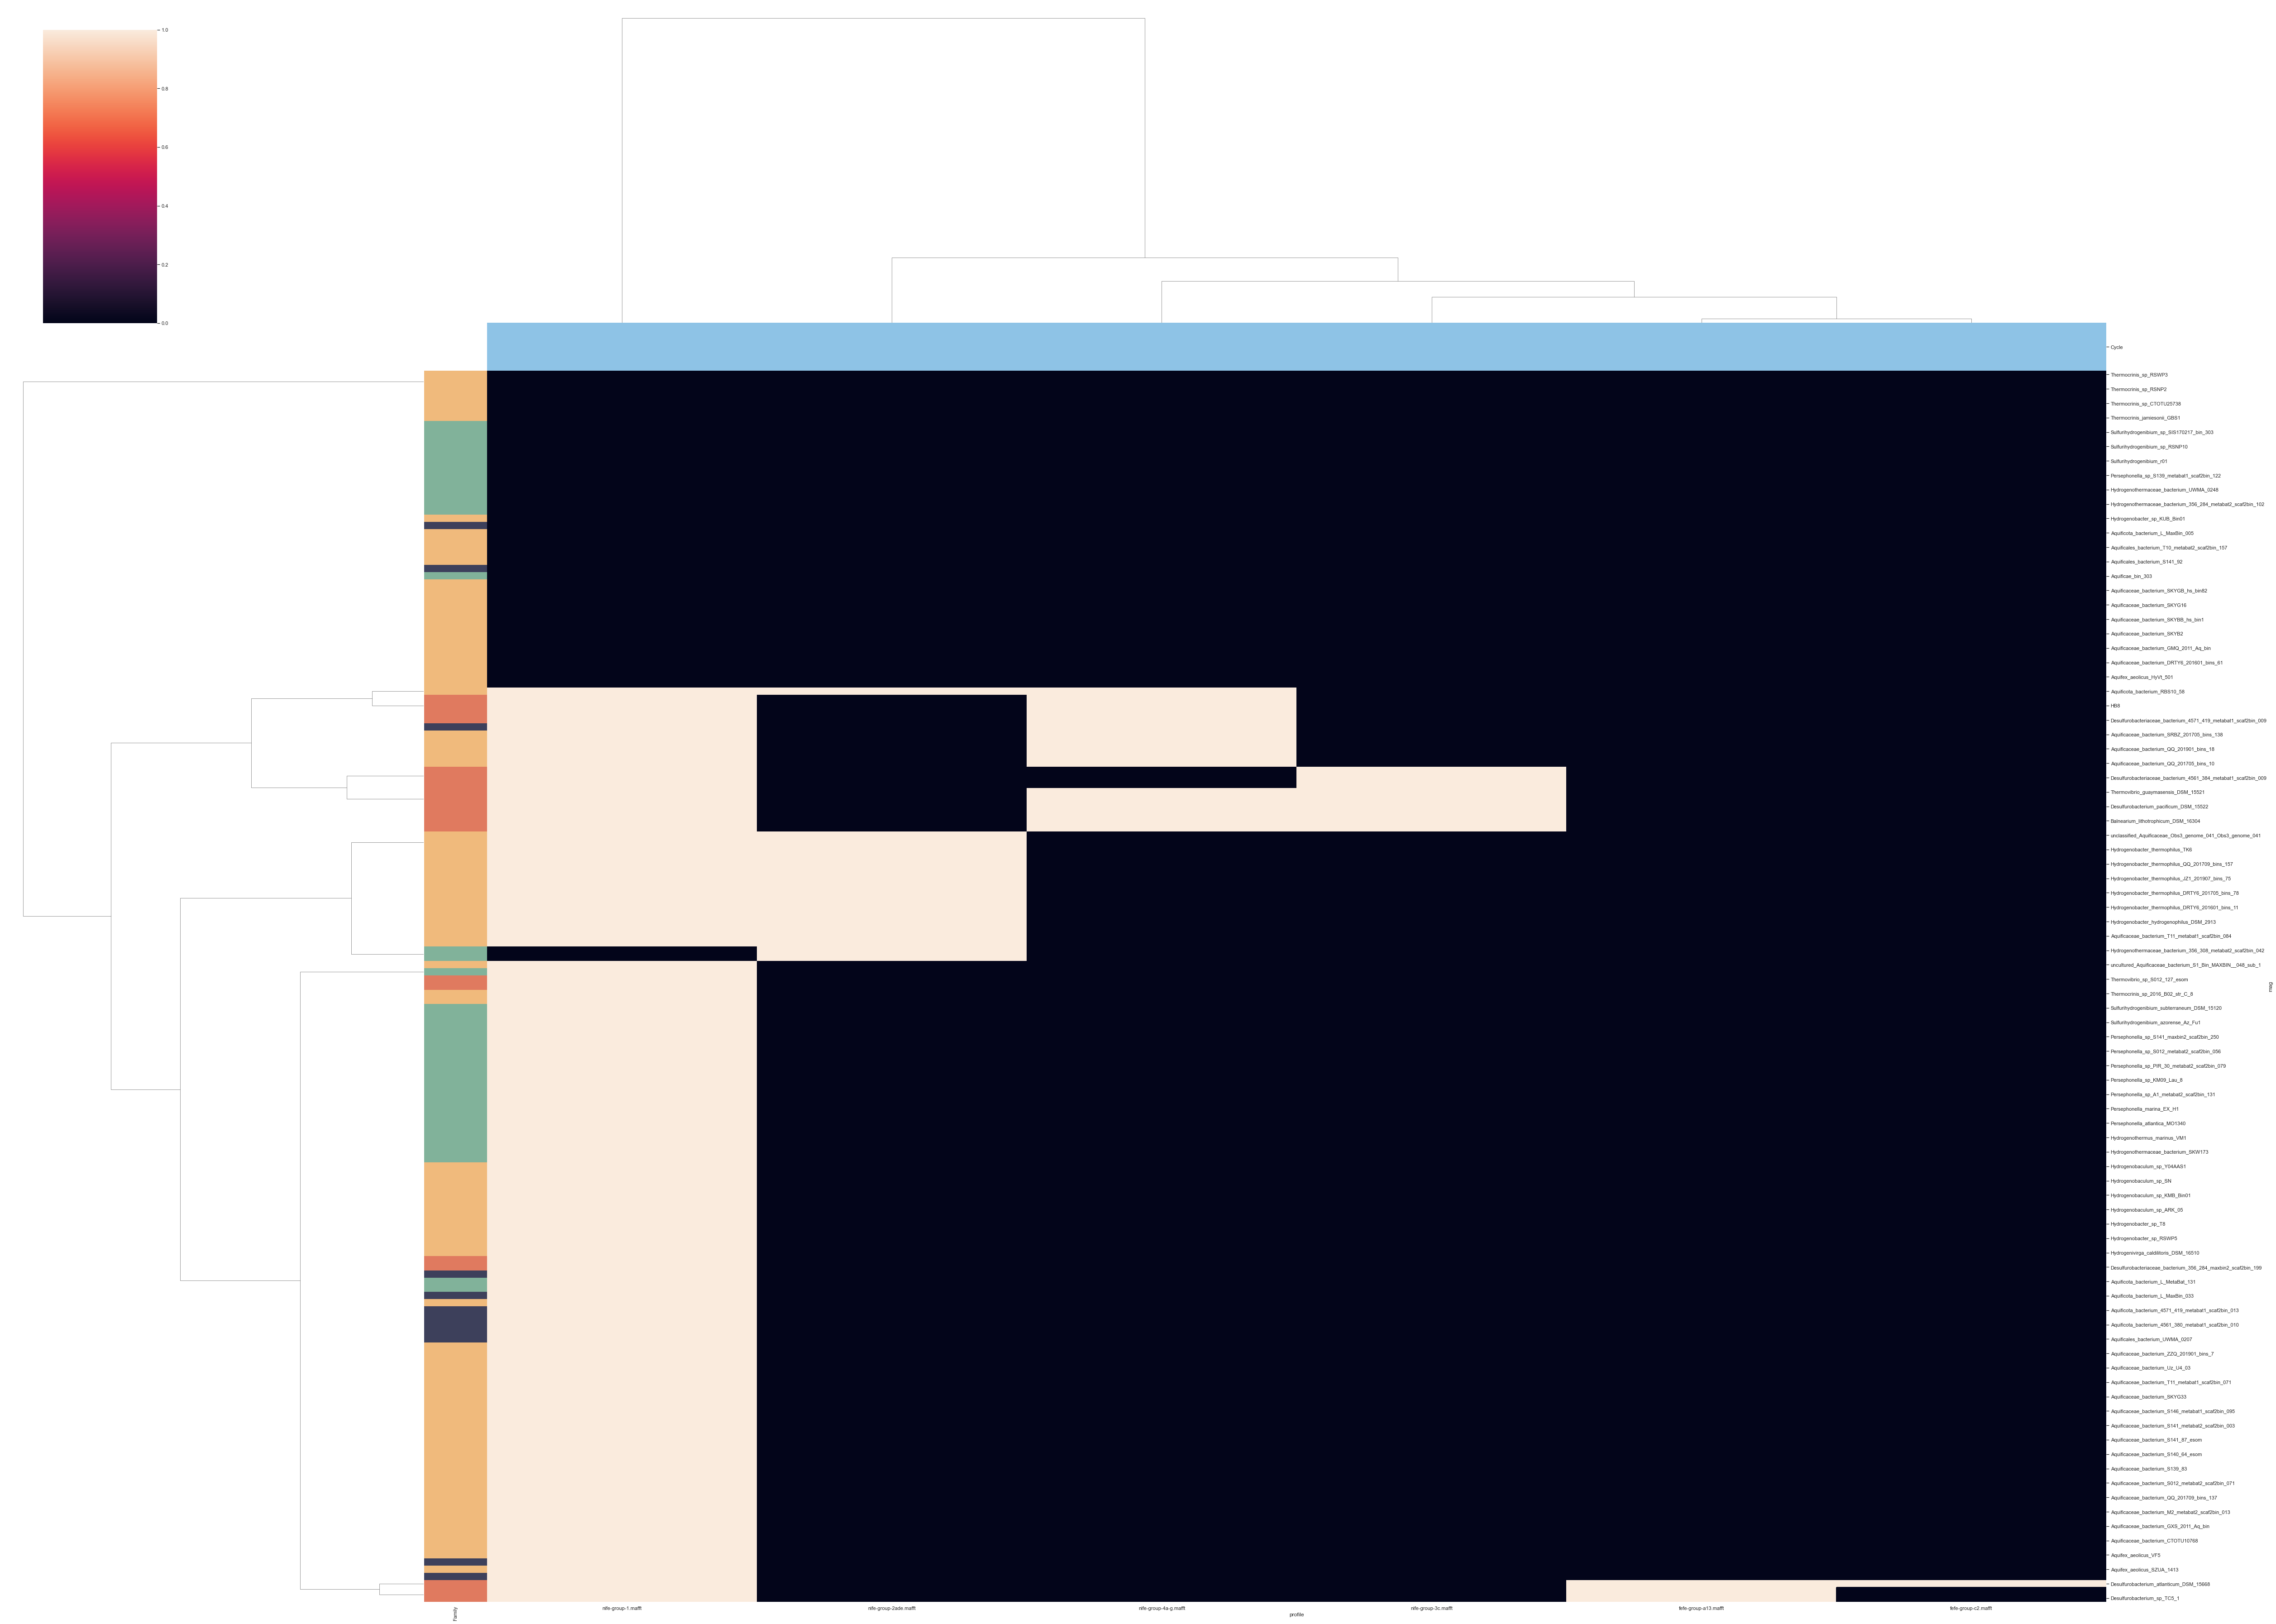

[+] Clustermap for cycle Selenium
[ERROR] Could not create clustermap for cycle Selenium: index 0 is out of bounds for axis 0 with size 0
[+] Clustermap for cycle Iron


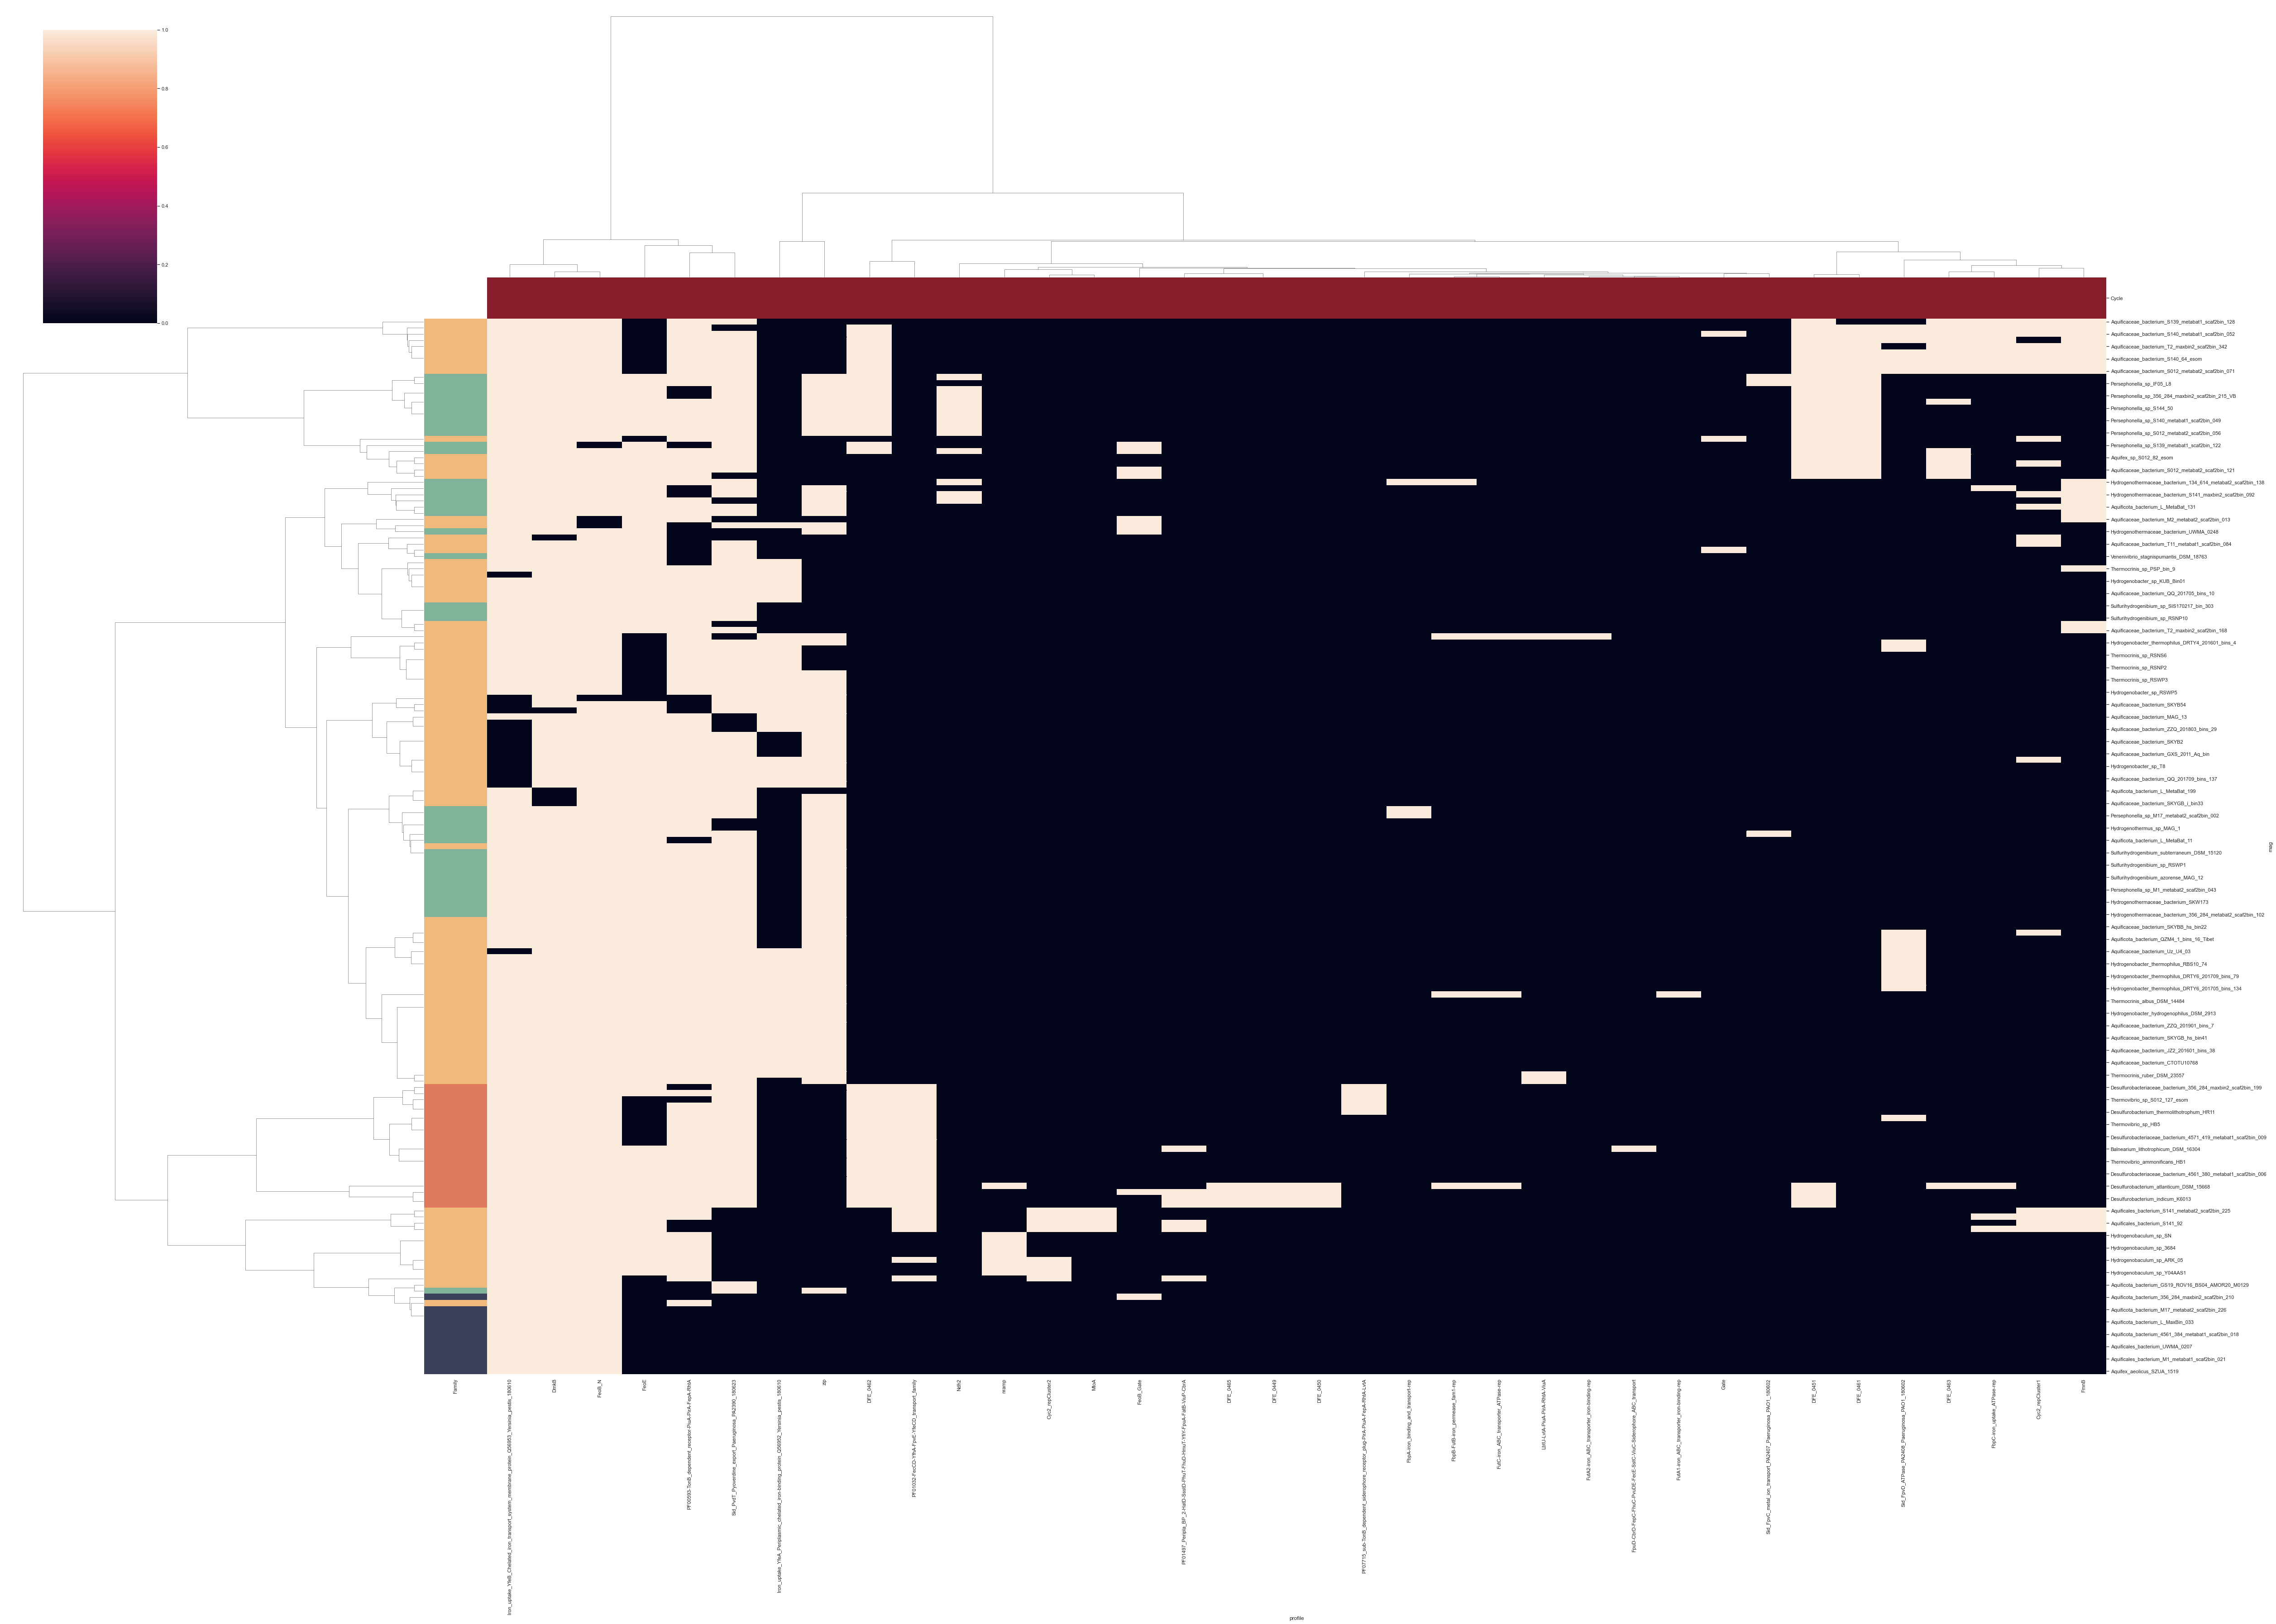

In [43]:
sns.set(font_scale=1.0)

for cycle in metadata_df["Cycle"].unique():

    cycle_hmm_models = metadata_df[
        metadata_df["Cycle"] == cycle
    ]["hmm_model"].unique()

    heat_df_cycle = heat_df[[
        col for col in heat_df.columns
        if col in cycle_hmm_models
    ]]

    try:
        print(f"[+] Clustermap for cycle {cycle}")
        sns.clustermap(
            data=heat_df_cycle,
            method=CLUSTERMAP_METHOD,
            metric=CLUSTERMAP_METRIC,
            col_colors=cycle_colors,
            row_colors=family_colors,
            figsize=(70, 50)
        )
        plt.savefig(
            os.path.join(
                DATA_DIR,
                f"heatmap-{'-'.join(SOURCES)}-cycle-{cycle.lower()}.svg"
            ),
            # dpi=300
        )
        plt.show()

    except Exception as error:
        print(f"[ERROR] Could not create clustermap for cycle {cycle}:", error)
        plt.close()


## HMM importances

In [72]:
def get_feat_imp(
    X: pd.DataFrame,
    y: pd.DataFrame,
    label_mapping: dict,
    random_seed: int = RANDOM_SEED
) -> pd.DataFrame:

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        stratify=y,
        random_state=random_seed
    )

    estimator = RandomForestClassifier(
        n_estimators=5,
        random_state=RANDOM_SEED
    )
    estimator.fit(X_train, y_train)

    print(
        label_mapping,
        "\n",
        classification_report(
            y_true=y_test,
            y_pred=estimator.predict(X_test)
        )
    )

    result = permutation_importance(
        estimator,
        X_test,
        y_test,
        n_repeats=20,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )

    forest_importances = pd.DataFrame({
        "feature": X_test.columns,
        "mean": result.importances_mean,
        "std": result.importances_std
    }).sort_values("mean", ascending=False)

    fig = px.bar(
        data_frame=forest_importances,
        x="feature",
        y="mean",
        error_y="std",
        labels={
            "feature": "HMM model",
            "mean": "Mean accuracy decrease",
            "std": "Mean accuracy decrease (std)"
        },
        title="HMM models - RF importances",
        template="plotly_white",
        height=900
    )
    fig.show()

    feat_imp = pd.DataFrame({
        "feature": X.columns,
        "mutual_info": fs.mutual_info_classif(
            X=X,
            y=y,
            discrete_features=True,
            n_neighbors=3,
            random_state=RANDOM_SEED
        )
    })

    # Add forest importances
    feat_imp = pd.merge(
        left=feat_imp,
        right=forest_importances\
            .drop("std", axis=1)\
            .rename(columns={"mean": "rf_importance_mean"}),
        on="feature",
        how="left"
    )

    # Add ANOVA and Chi2
    feat_imp[["anova_fvalue", "anova_pvalue"]] = \
        pd.DataFrame(fs.f_classif(X, y)).T
    feat_imp[["chi2", "chi2_pvalue"]] = \
        pd.DataFrame(fs.chi2(X, y)).T

    # Drop by significance threshold (must pass either test)
    feat_imp = feat_imp[
        (feat_imp["anova_pvalue"] <= SIGNIFICANCE_THR) &
        (feat_imp["chi2_pvalue"] <= SIGNIFICANCE_THR)
    ]

    # Sort values
    feat_imp = feat_imp.sort_values("anova_fvalue", ascending=False)

    feat_imp = feat_imp.melt(
        id_vars=["feature"],
        var_name="statistic",
        value_vars=[
            "rf_importance_mean",
            "mutual_info",
            "anova_fvalue",
            "chi2"
        ],
        value_name="value"
    )

    fig = px.bar(
        data_frame=feat_imp,
        x="feature",
        y="value",
        color="statistic",
        labels={
            "feature": "HMM model",
            "value": "Value",
            "statistic": "Statistic"
        },
        barmode="group",
        title="HMM models - Statistics",
        template="plotly_white",
        height=1200
    )
    fig.show()

    return feat_imp

#### Label: families

In [73]:
X = heat_df.copy()

# Get families in the same order as in heat_df
y = tax_df.set_index("Genomes").loc[heat_df.index]["Family"]

# Encode as categories
family_mapping = {family: idx for idx, family in enumerate(y.unique())}
y = y.map(family_mapping)

In [78]:
feat_imp = get_feat_imp(
    X=X,
    y=y,
    label_mapping=family_mapping
)

{'Aquificaceae': 0, 'QOAS01': 1, 'Hydrogenothermaceae': 2, 'Desulfurobacteriaceae': 3} 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.80      1.00      0.89         4
           2       1.00      0.92      0.96        12
           3       1.00      1.00      1.00         6

    accuracy                           0.98        52
   macro avg       0.95      0.98      0.96        52
weighted avg       0.98      0.98      0.98        52



#### Label: aerobic/anaerobic

In [75]:
# Get in the same order as in heat_df
y_aero = tax_df.set_index("Genomes").loc[heat_df.index]["Family"]

# Encode as categories
aerobic_mapping = {
    "Desulfurobacteriaceae": 0,
    "Hydrogenothermaceae": 1,
    "Aquificaceae": 1,
    "QOAS01": 0
}
y_aero = y_aero.map(aerobic_mapping)

In [77]:
feat_imp_aero = get_feat_imp(
    X=X,
    y=y,
    label_mapping=aerobic_mapping
)

{'Desulfurobacteriaceae': 0, 'Hydrogenothermaceae': 1, 'Aquificaceae': 1, 'QOAS01': 0} 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.80      1.00      0.89         4
           2       1.00      0.92      0.96        12
           3       1.00      1.00      1.00         6

    accuracy                           0.98        52
   macro avg       0.95      0.98      0.96        52
weighted avg       0.98      0.98      0.98        52



## Get CSV with the data from significant hits

#### Separating between families

In [54]:
#Format rows

feat_imp["feature"] = feat_imp["feature"].str.replace("barosa_", "")

#merge with the metadata df to better parse the significant values

merged_families = pd.merge(
            feat_imp, 
            metadata_df, 
            how="left", 
            left_on="feature", 
            right_on="hmm_model"
)

merged_families.to_csv(
            os.path.join(
                DATA_DIR,
                f"families_top_hits_3.csv"
            ),
            index=False,
        )

#### Separating aerobic versus anaerobic

In [55]:
#Format rows

feat_imp_aero["feature"] = feat_imp_aero["feature"].str.replace("barosa_", "")


#merge with the metadata df to better parse the significant values

merged_aerobic = pd.merge(
            feat_imp_aero, 
            metadata_df, 
            how="left", 
            left_on="feature", 
            right_on="hmm_model"
)

merged_aerobic.to_csv(
            os.path.join(
                DATA_DIR,
                f"aerobic_top_hits.csv"
            ),
            index=False,
        )

## CREATE TREE ANOTATIONS

In [56]:
tree = Phylo.read(
    file=os.path.join(
        DATA_DIR,
        TREE_FILE
    ),
    format="newick"
)

NameError: name 'TREE_FILE' is not defined

##### Get the accurate family names

In [ ]:
tree_df = pd.DataFrame.from_dict({
    "genome_name": [branch.name for branch in tree.get_terminals()]
})

tree_df["genome_name"] = tree_df["genome_name"]

tree_df


genome_name
0                         Aquifex_aeolicus_HyVt_501_187
1                         Aquifex_aeolicus_HyVt_501_519
2     Aquificaceae_bacterium_T2_maxbin2_scaf2bin_342...
3     Aquificaceae_bacterium_S012_metabat2_scaf2bin_...
4     Aquificaceae_bacterium_S140_metabat1_scaf2bin_...
...                                                 ...
2676                 Aquificaceae_bacterium_S139_83_680
2677            Aquificaceae_bacterium_S140_64_esom_459
2678  Aquificaceae_bacterium_S139_metabat1_scaf2bin_...
2679  Aquificaceae_bacterium_S146_metabat1_scaf2bin_...
2680  Aquificaceae_bacterium_S141_metabat2_scaf2bin_...

[2681 rows x 1 columns]

In [ ]:
id_match = pd.merge(
    left=tree_df,
    right=tax_df,
    how="left",
    left_on="genome_name", 
    right_on="Genomes",
    indicator="merge"
)
id_match_unique = id_match.drop_duplicates(subset="genome_name")
id_match_unique

genome_name  \
0                            Aquifex_aeolicus_HyVt_501   
2       Aquificaceae_bacterium_T2_maxbin2_scaf2bin_342   
3    Aquificaceae_bacterium_S012_metabat2_scaf2bin_071   
4    Aquificaceae_bacterium_S140_metabat1_scaf2bin_052   
5    Aquificaceae_bacterium_S141_metabat2_scaf2bin_003   
..                                                 ...   
502  Aquificota_bacterium_356_284_maxbin2_scaf2bin_210   
503                  Aquificota_bacterium_L_MaxBin_033   
742               Aquificaceae_bacterium_SKYBB_hs_bin1   
746              Aquificaceae_bacterium_SKYGB_hs_bin82   
890        Aquificaceae_bacterium_DRTY6_201601_bins_61   

                                               Genomes         Phylum  \
0                            Aquifex_aeolicus_HyVt_501  p__Aquificota   
2       Aquificaceae_bacterium_T2_maxbin2_scaf2bin_342  p__Aquificota   
3    Aquificaceae_bacterium_S012_metabat2_scaf2bin_071  p__Aquificota   
4    Aquificaceae_bacterium_S140_metabat1_scaf2bin_052  p__Aquificota   
5    Aquificaceae_bacterium_S141_metabat2_scaf2bin_003  p__Aquificota   
..                                                 ...            ...   
502  Aquificota_bacterium_356_284_maxbin2_scaf2bin_210  p__Aquificota   
503                  Aquificota_bacterium_L_MaxBin_033  p__Aquificota   
742               Aquificaceae_bacterium_SKYBB_hs_bin1  p__Aquificota   
746              Aquificaceae_bacterium_SKYGB_hs_bin82  p__Aquificota   
890        Aquificaceae_bacterium_DRTY6_201601_bins_61  p__Aquificota   

            Class           Order        Family              Genus  \
0    c__Aquificae  o__Aquificales  Aquificaceae  g__Hydrogenivirga   
2    c__Aquificae  o__Aquificales  Aquificaceae  g__Hydrogenivirga   
3    c__Aquificae  o__Aquificales  Aquificaceae  g__Hydrogenivirga   
4    c__Aquificae  o__Aquificales  Aquificaceae  g__Hydrogenivirga   
5    c__Aquificae  o__Aquificales  Aquificaceae  g__Hydrogenivirga   
..            ...             ...           ...                ...   
502  c__Aquificae  o__Aquificales        QOAS01          g__QOAS01   
503  c__Aquificae  o__Aquificales        QOAS01          g__QOAS01   
742  c__Aquificae  o__Aquificales  Aquificaceae        g__UBA11096   
746  c__Aquificae  o__Aquificales  Aquificaceae        g__UBA11096   
890  c__Aquificae  o__Aquificales  Aquificaceae        g__UBA11096   

    family_colors merge  
0       #f0ba7cff  both  
2       #f0ba7cff  both  
3       #f0ba7cff  both  
4       #f0ba7cff  both  
5       #f0ba7cff  both  
..            ...   ...  
502       #3D405B  both  
503       #3D405B  both  
742     #f0ba7cff  both  
746     #f0ba7cff  both  
890     #f0ba7cff  both  

[171 rows x 9 columns]

##### Get the accurate hydrogenase group annotations

In [ ]:
tree_df = pd.DataFrame.from_dict({
    "genome_name": [branch.name for branch in tree.get_terminals()]
})
tree_df

genome_name
0                         Aquifex_aeolicus_HyVt_501_187
1                         Aquifex_aeolicus_HyVt_501_519
2     Aquificaceae_bacterium_T2_maxbin2_scaf2bin_342...
3     Aquificaceae_bacterium_S012_metabat2_scaf2bin_...
4     Aquificaceae_bacterium_S140_metabat1_scaf2bin_...
...                                                 ...
2676                 Aquificaceae_bacterium_S139_83_680
2677            Aquificaceae_bacterium_S140_64_esom_459
2678  Aquificaceae_bacterium_S139_metabat1_scaf2bin_...
2679  Aquificaceae_bacterium_S146_metabat1_scaf2bin_...
2680  Aquificaceae_bacterium_S141_metabat2_scaf2bin_...

[2681 rows x 1 columns]

In [ ]:
id_match_hyd = pd.merge(
    left=tree_df,
    right=hits_df,
    how="left",
    left_on="genome_name", 
    right_on="target_name",
    indicator="merge"
)
id_match_hyd = id_match_hyd[["genome_name", "query_name"]]

id_match_hyd["query_name"] = id_match_hyd["query_name"].str.replace("barosa.source.hmm_", "")
id_match_hyd["query_name"] = id_match_hyd["query_name"].str.replace(".mafft", "")
id_match_hyd


genome_name      query_name
0                         Aquifex_aeolicus_HyVt_501_187  fefe-group-a13
1                         Aquifex_aeolicus_HyVt_501_519  fefe-group-a13
2     Aquificaceae_bacterium_T2_maxbin2_scaf2bin_342...  fefe-group-a13
3     Aquificaceae_bacterium_S012_metabat2_scaf2bin_...  fefe-group-a13
4     Aquificaceae_bacterium_S140_metabat1_scaf2bin_...  fefe-group-a13
...                                                 ...             ...
2676                 Aquificaceae_bacterium_S139_83_680  fefe-group-a13
2677            Aquificaceae_bacterium_S140_64_esom_459  fefe-group-a13
2678  Aquificaceae_bacterium_S139_metabat1_scaf2bin_...  fefe-group-a13
2679  Aquificaceae_bacterium_S146_metabat1_scaf2bin_...  fefe-group-a13
2680  Aquificaceae_bacterium_S141_metabat2_scaf2bin_...  fefe-group-a13

[2681 rows x 2 columns]

### Create the iTOL template


In [ ]:
from modules.itol import get_itol_template


template_path = os.path.join(
    DATA_DIR,
    "itol-annotation-template.txt"
)

#### Annotation: hydrogenase groups

In [ ]:
for group in id_match_hyd["genome_name"].unique():

    group_df = id_match_hyd[id_match_hyd["genome_name"] == group]

    template_mod = get_itol_template(
        df=group_df,
        template_path=template_path
    )

    template_path_mod = template_path.replace("-template", f"-{group}")

    with open(template_path_mod, mode="w") as handle:
        handle.write(template_mod)


KeyError: 'group'

In [ ]:
for group in id_match_hyd["query_name"].unique():

    group_df = id_match_hyd[id_match_hyd["query_name"] == group]
   
    template_mod = get_itol_template(
        df=group_df,
        template_path=template_path
    )

KeyError: 'group'